In [3]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'TJ-BG-AT-SX-CC-MV'
board_name = ['Tech_job','Boy-Girl','AllTogether','sex','C_Chat','movie']
board_dict_index = {'Tech_job':0,'Boy-Girl':1,'AllTogether':2,'sex':3,'C_Chat':4,'movie':5}

max_word_length = 500
min_word_length = 100
max_title_length = 20
words_limit = 30000
label_newnum = len(board_name)

GO_id = '<go>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import jieba
import json

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_label = []
text_generator = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character.
    text = GO_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Split titles to words by Jieba.
    title_name.encode('utf-8-sig')
    title_jieba = jieba.cut(title_name, cut_all=False)
    title_name = GO_id
    word_length = 0
    for word in title_jieba:
        word_length += 1
        title_name = title_name + ' ' + word.lower()
    else:
        title_name = title_name + ' ' + EOS_id

    text_content.append(text)
    text_label.append(board_dict_index[this_board_name])
    text_generator.append(title_name)
    file.close()

# Build vocabulary and convert content to sequence by Keras tool.
tokenizer = Tokenizer(num_words=words_limit, 
                      filters='!"#$%&()*+,×-./:;=?@[\\]^_`{|}~\t\n　，。！：；、？＜＞﹝﹞「」『』（）｛｝［］【】《》〖〗﹙﹚“”‘’＼﹨｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％⌒‿︵︷︹︻︽︿﹁﹃︶︸︺︼︾﹀﹂﹄＆～§◎．˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔', 
                      lower=True,
                      split=" ")
                      #oov_token=UNK_word)
tokenizer.fit_on_texts(text_content+text_generator)
vocab_sort = tokenizer.word_index
vocab_counts = tokenizer.word_counts
vocab_docs = tokenizer.word_docs

print('Vocabulary size after jieba: ', len(vocab_sort))
vocab = {}
vocab_reverse = {}
vocab_keys = list(vocab_sort.keys())
for vocab_word in vocab_keys:
    vocab_index = vocab_sort[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
        vocab[vocab_keys[vocab_index-1]] = vocab_index
        if vocab_index % 1000 == 0 or vocab_index < 100:
            print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                  vocab_counts[vocab_word], vocab_docs[vocab_word])
else:
    #vocab[GO_id] = words_limit + 1
    #vocab_reverse[words_limit + 1] = GO_id
    #vocab[EOS_id] = words_limit + 2
    #vocab_reverse[words_limit + 2] = EOS_id
    vocab[UNK_id] = words_limit + 3
    vocab_reverse[words_limit + 3] = UNK_id

# Save vocabulary information.
with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_sort))
with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_counts))
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_docs))
with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab))
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_reverse))

# 將單字轉換成字庫的索引值
total_content_word_ids = tokenizer.texts_to_sequences(text_content+text_generator)
total_content_size = [len(word_ids) for word_ids in total_content_word_ids]

Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 1.113 seconds.
Prefix dict has been built succesfully.


Vocabulary size after jieba:  408129
1 的 的 1528464 182196
2 我 我 625628 114664
3 是 是 470208 130016
4 了 了 397176 118384
5 在 在 301650 113075
6 有 有 295344 116801
7 <go> <go> 288000 288000
8 <eos> <eos> 288000 288000
9 也 也 284847 106795
10 就 就 230816 94446
11 都 都 222566 97970
12 不 不 199621 94240
13 你 你 191862 58316
14 他 他 189026 51030
15 很 很 170578 79814
16 會 會 160456 81797
17 她 她 152495 33733
18 說 說 144243 69259
19 跟 跟 142471 69267
20 人 人 141724 74582
21 可以 可以 128643 68804
22 但 但 127297 67849
23 要 要 127190 70160
24 看 看 116588 63841
25 想 想 108582 66993
26 好 好 104944 64966
27 自己 自己 101992 53664
28 到 到 96895 61275
29 去 去 95909 55591
30 為 為 89048 56652
31 一個 一個 86611 53316
32 沒有 沒有 85362 53649
33 被 被 85267 51755
34 因為 因為 84360 54045
35 嗎 嗎 83209 57277
36 就是 就是 79957 50464
37 讓 讓 78324 49148
38 覺得 覺得 76739 45260
39 電影 電影 74385 34227
40 和 和 74153 41164
41 沒 沒 73738 48517
42 喜歡 喜歡 73104 37800
43 什麼 什麼 72605 47092
44 還是 還是 71578 49452
45 對 對 71446 46965
46 知道 知道 71370 47183
47 所以 所以 71300 47083
48

In [4]:
print('Vocabulary size: ', len(vocab))

skip_window = 1 # How many words to consider left and right.
num_skips = 2*skip_window # How many times to reuse an input to generate a context.
sample_threshold = 0.0002

# Set sampling rate for word using frequency.
def sampling_rate(sample_num, total_num, sample_threshold):
    z_rate = sample_num/total_num/sample_threshold
    return min((np.sqrt(z_rate) + 1.0)/z_rate, 1.0)

# Compute context word size
def context_word_size(content_size, skip_window):
    return content_size * skip_window * 2

total_context_size = [context_word_size(word_ids,skip_window) for word_ids in total_content_size]
sum_context_size = sum(total_context_size)
print('Sum over all context size: ',sum_context_size)

sum_vocab_counts = 0
unk_count = 0
for vocab_word in vocab_sort:
    vocab_index = vocab_sort[vocab_word]
    sum_vocab_counts += vocab_counts[vocab_word]
    if vocab_index > words_limit+2:
        unk_count += vocab_counts[vocab_word]
print('Sum over all vocabulary counts: ',sum_vocab_counts)

# Build sampling rate dict for vocabulary.
vocab_rate = {}
for vocab_word in vocab:
    vocab_index = vocab[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_rate[vocab_index] = sampling_rate(vocab_counts[vocab_word], 
                                        sum_vocab_counts, sample_threshold)
    else:
        assert vocab_word == UNK_id
        vocab_rate[vocab_index] = sampling_rate(unk_count, 
                             sum_vocab_counts, sample_threshold)
        break

# Convert text content to context inputs and labels array.
def generate_context(content_ids, content_size, skip_window):
    context_size = context_word_size(content_size, skip_window)
    inputs = np.ndarray(shape=(context_size), dtype=np.int32)
    labels = np.ndarray(shape=(context_size, 1), dtype=np.int32)
    for i in range(content_size):
        for j in range(skip_window):
            inputs[(i*skip_window+j)*2] = content_ids[i]
            inputs[(i*skip_window+j)*2+1] = content_ids[i]
            if i-j-1>=0:
                labels[(i*skip_window+j)*2] = content_ids[i-j-1]
            else:
                labels[(i*skip_window+j)*2] = 0
            if i+j+1<content_size:
                labels[(i*skip_window+j)*2+1] = content_ids[i+j+1]
            else:
                labels[(i*skip_window+j)*2+1] = 0
    return inputs, labels

# Build all of context inputs and labels by array.
total_inputs = np.ndarray(shape=(sum_context_size), dtype=np.int32)
total_labels = np.ndarray(shape=(sum_context_size, 1), dtype=np.int32)
context_index = 0
for word_ids, word_size in zip(total_content_word_ids, total_content_size):
    inputs, labels = generate_context(word_ids, word_size, skip_window)
    context_size = context_word_size(word_size, skip_window)
    total_inputs[context_index:context_index+context_size] = inputs
    total_labels[context_index:context_index+context_size,:] = labels
    context_index += context_size
else:
    assert context_index == sum_context_size

# If the word id was out of vocabulary, reset id to UNK_id.
np.minimum(total_inputs, words_limit + 3, total_inputs)
np.minimum(total_labels, words_limit + 3, total_labels)

Vocabulary size:  30003
Sum over all context size:  59901418
Sum over all vocabulary counts:  32083267


array([[    0],
       [ 1274],
       [    7],
       ...,
       [    8],
       [12086],
       [    0]])


epoch1
Iteration  32633  ( 10.0 %) Train mean loss:  32.536633  ( std:  12.708132 ) ; run time:  96 [s]
Iteration  65297  ( 20.0 %) Train mean loss:  25.817345  ( std:  12.830483 ) ; run time:  194 [s]
Iteration  97926  ( 30.0 %) Train mean loss:  21.482658  ( std:  12.606208 ) ; run time:  293 [s]
Iteration  130555  ( 40.0 %) Train mean loss:  18.494747  ( std:  12.255822 ) ; run time:  391 [s]
Iteration  163198  ( 50.0 %) Train mean loss:  16.331259  ( std:  11.857345 ) ; run time:  488 [s]
Iteration  195845  ( 60.0 %) Train mean loss:  14.6994295  ( std:  11.457542 ) ; run time:  587 [s]
Iteration  228486  ( 70.0 %) Train mean loss:  13.428308  ( std:  11.07469 ) ; run time:  687 [s]
Iteration  261134  ( 80.0 %) Train mean loss:  12.407022  ( std:  10.717206 ) ; run time:  785 [s]
Iteration  293778  ( 90.0 %) Train mean loss:  11.569888  ( std:  10.385186 ) ; run time:  882 [s]
Iteration  326413  ( 100.0 %) Train mean loss:  10.868929  ( std:  10.079064 ) ; run time:  980 [s]
Save 

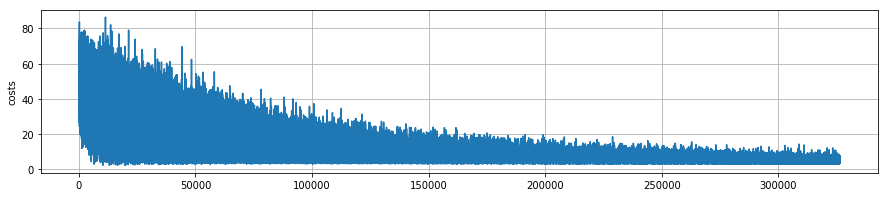

Nearest to <go>: 銘言, 此時, 不過, 新手, 造型, 深愛, 惹, 誤導, 完整, 知名,
Nearest to 我: 他, 要求, 立場, 請假, 一次, 在, 就, 多一點, 偏好, 你,
Nearest to 台灣: 註, 今年, 國片, 成年, 手法, 這部, 正當, 可愛, 妻子, 美國,
Nearest to 工作: 網路, 洗, 轉職, 統一, 福利, 畢業, 自, 心智, 樣子, 妳會,
Nearest to 喜歡: 刪掉, 打鬥, 總之, 妳, 半年, 就業, 法人, 常, 莫名其妙, 意外,
Nearest to 可以: 永遠, 小林, 站內信, 開發, よ, 追求, 人資, 阿, 能, 既然,
Nearest to 約: 隨, 保護, 打, 凹, 32, 藍色, 噁心, 運氣, 歐, 抱怨,
Nearest to 電影: 喜劇, 同步, 弄, 賭博, 接觸, 總結, 異常, 地方, 旅遊, 65,
Nearest to 時間: 瞬間, 好, 職業, 甚麼, 課, 精神, 投票, 求解, 保持, 出來,
Nearest to 滿足: 平衡, 內向, 隻, 大膽, 南部, 寫信, 恐怖片, 光學, 偏好, 明星,
Nearest to 閃光: 廢話, 金鋼, 大叔, 辦, 遇過, 熟人, 挫折, 暗示, 這份, 聯合報,
Nearest to <eos>: 例如, 大多數, 味道, 謝謝, 樣子, 接近, 口頭, 約炮, 職缺, 金牌,

epoch2
Iteration  32634  ( 10.0 %) Train mean loss:  4.302589  ( std:  0.84967184 ) ; run time:  100 [s]
Iteration  65280  ( 20.0 %) Train mean loss:  4.2053537  ( std:  0.80017966 ) ; run time:  197 [s]
Iteration  97918  ( 30.0 %) Train mean loss:  4.1166296  ( std:  0.7621111 ) ; run time:  296 [s]
Iteration  130548  ( 40.0 %) Train mean loss:  4.

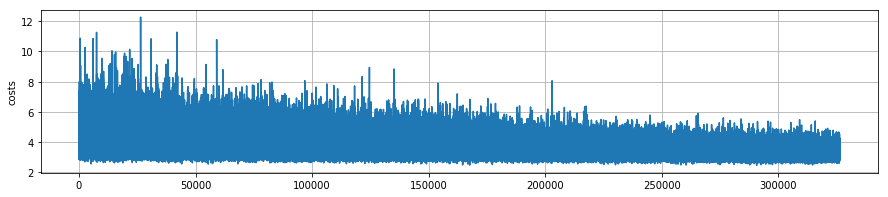

Nearest to <go>: 銘言, 深愛, 誤導, 此時, 驚覺, 新手, 成行, 華爾街, 不過, 蘿莉控,
Nearest to 我: 他, 立場, 你, 永恆, 請假, 多一點, 鬆散, 香草, 多月, 要求,
Nearest to 台灣: 註, 成年, 美國, 今年, 攻殼, 女警, 日本, 生產線, 國片, 西班牙,
Nearest to 工作: 心智, 網路, 統一, 處女座, 薪資, 事宜, 洗, 轉職, 妳會, 見諒,
Nearest to 喜歡: 刪掉, 打鬥, 總之, 撲, 侍, 葉問, 可填, 莫名其妙, 就業, 妳,
Nearest to 可以: 能, 小林, 補辦, 班底, 崩塌, 可, 站內信, よ, 永遠, 科技股份,
Nearest to 約: 隨, 凹, 每天晚上, 改天, 打, 32, 保護, 運氣, 歐, 雄,
Nearest to 電影: 喜劇, 同步, 賭博, 總結, 65, 旅遊, 異常, 49, 弄, 太遠,
Nearest to 時間: 瞬間, 職業, 求解, 好, 規畫, 甚麼, 課, 精神, 投票, 糖果,
Nearest to 滿足: 這還, 內向, 寫信, 我先, 平衡, 硬要, 大膽, 光學, 名言, 吹出來,
Nearest to 閃光: 廢話, 熟人, 金鋼, 挫折, 領獎, 大叔, 平行, 辦, 闖, 很常,
Nearest to <eos>: 謝謝, n314, 例如, 地下, い, 大多數, 過濾, 這首, 倘若, 口頭,

epoch3
Iteration  32640  ( 10.0 %) Train mean loss:  3.2172995  ( std:  0.29480216 ) ; run time:  98 [s]
Iteration  65282  ( 20.0 %) Train mean loss:  3.1959503  ( std:  0.28354824 ) ; run time:  197 [s]
Iteration  97932  ( 30.0 %) Train mean loss:  3.173309  ( std:  0.27446452 ) ; run time:  296 [s]
Iteration  130564  ( 40.0 %) Train mea

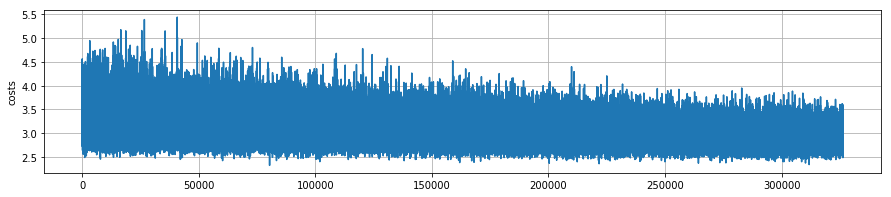

Nearest to <go>: 銘言, 成行, 深愛, 驚覺, 此時, 誤導, 新手, 惹, 華爾街, 摔角,
Nearest to 我: 他, 你, 永恆, 立場, 香草, 鬆散, 請假, 雙重標準, 卻步, 她們,
Nearest to 台灣: 美國, 註, 日本, 女警, 成年, 攻殼, 今年, 西班牙, 國片, 生產線,
Nearest to 工作: 心智, 處女座, 薪資, 統一, 網路, 洗, 事宜, 街道, 轉職, 卍,
Nearest to 喜歡: 刪掉, 打鬥, 撲, 總之, 討厭, 侍, 看準, 木葉, 跳過去, 葉問,
Nearest to 可以: 能, 崩塌, 可, 能夠, 補辦, 班底, 小林, 三條, 科技股份, 站內信,
Nearest to 約: 凹, 每天晚上, 隨, 改天, 超過, 打, 雄, 鮪, 聽來, 酒杯,
Nearest to 電影: 喜劇, 同步, 賭博, 總結, 旅遊, 49, 誰錯, 65, 小說, 動漫畫,
Nearest to 時間: 瞬間, 職業, 求解, 規畫, 好, 捨得, 糖果, 課, 彼此間, 精神,
Nearest to 滿足: 這還, 寫信, 我先, 內向, 硬要, 吹出來, 艾蜜莉, 平衡, 濫用, 名言,
Nearest to 閃光: 廢話, 熟人, 金鋼, 領獎, 大叔, 挫折, 平行, 闖, 俗稱, 很常,
Nearest to <eos>: 謝謝, sent, n314, 例如, い, 凝視, 過濾, 倘若, 地下, 這首,

epoch4
Iteration  32657  ( 10.0 %) Train mean loss:  2.8951597  ( std:  0.1657752 ) ; run time:  95 [s]
Iteration  65301  ( 20.0 %) Train mean loss:  2.8876672  ( std:  0.16352911 ) ; run time:  190 [s]
Iteration  97938  ( 30.0 %) Train mean loss:  2.8809886  ( std:  0.16203012 ) ; run time:  284 [s]
Iteration  130569  ( 40.0 %) Trai

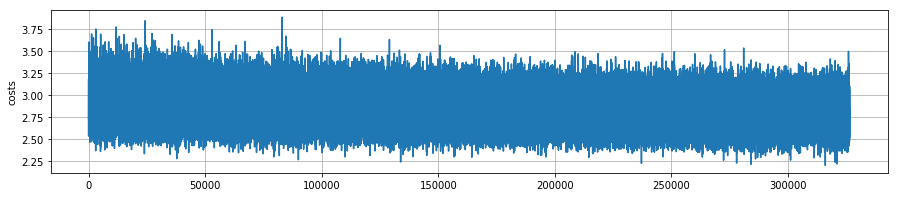

Nearest to <go>: 銘言, 成行, 深愛, 驚覺, 此時, 摔角, 惹, 新創, 新手, 誤導,
Nearest to 我: 他, 你, 永恆, 立場, 鬆散, 香草, 她, 雙重標準, 她們, 卻步,
Nearest to 台灣: 日本, 美國, 女警, 註, 攻殼, 成年, 西班牙, 今年, 國片, 生產線,
Nearest to 工作: 心智, 薪資, 處女座, 洗, 街道, 卍, 取而代之, 統一, 半點, 事宜,
Nearest to 喜歡: 刪掉, 討厭, 打鬥, 看準, 撲, 跳過去, 個性, 木葉, 侍, 總之,
Nearest to 可以: 能, 能夠, 可, 崩塌, 三條, 班底, 補辦, 小林, 少部分, 不能,
Nearest to 約: 凹, 每天晚上, 隨, 超過, 改天, 鮪, 說原, 聽來, 雄, 打,
Nearest to 電影: 喜劇, 同步, 賭博, 總結, 旅遊, 49, 腰身, 誰錯, 小說, 車手,
Nearest to 時間: 瞬間, 職業, 捨得, 規畫, 求解, 糖果, 催婚, 好, 彼此間, 面孔,
Nearest to 滿足: 這還, 寫信, 我先, 吹出來, 硬要, 艾蜜莉, 內向, 為過, 不容許, 呼聲,
Nearest to 閃光: 熟人, 廢話, 金鋼, 領獎, 大叔, 挫折, 闖, 俗稱, 平行, 夫妻倆,
Nearest to <eos>: sent, 謝謝, n314, 例如, 凝視, い, 倘若, 過濾, 萬華區, 不如意,

epoch5
Iteration  32626  ( 10.0 %) Train mean loss:  2.7683673  ( std:  0.14422567 ) ; run time:  97 [s]
Iteration  65271  ( 20.0 %) Train mean loss:  2.7670465  ( std:  0.14307426 ) ; run time:  190 [s]
Iteration  97912  ( 30.0 %) Train mean loss:  2.7641292  ( std:  0.14317177 ) ; run time:  281 [s]
Iteration  130554  ( 40.0 %) T

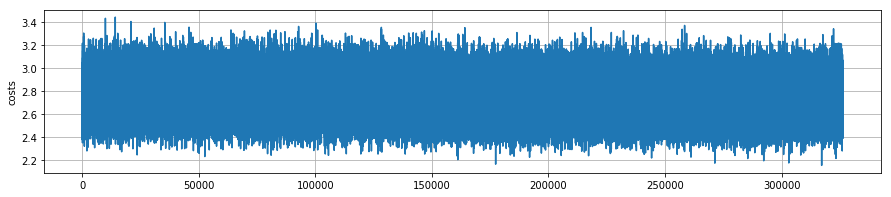

Nearest to <go>: 銘言, 成行, 驚覺, 深愛, 惹, 報導, 摔角, 新創, 風靡, 此時,
Nearest to 我: 他, 你, 她, 永恆, 立場, 鬆散, 香草, 她們, 卻步, 雙重標準,
Nearest to 台灣: 日本, 美國, 女警, 攻殼, 註, 成年, 西班牙, 國片, 今年, 據傳,
Nearest to 工作: 心智, 薪資, 處女座, 取而代之, 洗, 卍, 街道, 半點, 轉職, 統一,
Nearest to 喜歡: 討厭, 刪掉, 看準, 個性, 愛, 跳過去, 撲, 打鬥, 22y, 木葉,
Nearest to 可以: 能, 能夠, 可, 崩塌, 三條, 班底, 少部分, 不能, 補辦, 無法,
Nearest to 約: 凹, 每天晚上, 超過, 隨, 改天, 說原, 鮪, 聽來, 雄, 好爽,
Nearest to 電影: 喜劇, 同步, 賭博, 腰身, 旅遊, 總結, 誰錯, 小說, 49, 車手,
Nearest to 時間: 瞬間, 捨得, 職業, 規畫, 催婚, 糖果, 求解, 面孔, 彼此間, 好,
Nearest to 滿足: 這還, 寫信, 我先, 硬要, 吹出來, 為過, 艾蜜莉, 不容許, 呼聲, 濫用,
Nearest to 閃光: 熟人, 廢話, 金鋼, 大叔, 領獎, 補辦, 夫妻倆, 挫折, 闖, 很常,
Nearest to <eos>: sent, 謝謝, n314, 凝視, 例如, い, 倘若, 萬華區, 不如意, 投球,

epoch6
Iteration  32644  ( 10.0 %) Train mean loss:  2.7079704  ( std:  0.14129995 ) ; run time:  90 [s]
Iteration  65274  ( 20.0 %) Train mean loss:  2.7070217  ( std:  0.14154184 ) ; run time:  187 [s]
Iteration  97923  ( 30.0 %) Train mean loss:  2.705631  ( std:  0.14179681 ) ; run time:  284 [s]
Iteration  130559  ( 40.0 %) T

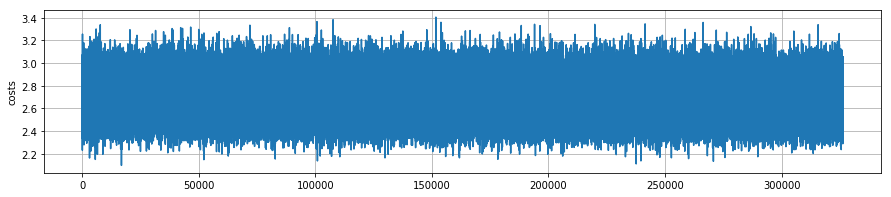

Nearest to <go>: 銘言, 成行, 報導, 驚覺, 惹, 深愛, 知道, 新創, 摔角, 決戰,
Nearest to 我: 他, 你, 她, 永恆, 鬆散, 立場, 她們, 妳, 香草, 卻步,
Nearest to 台灣: 日本, 美國, 女警, 攻殼, 據傳, 國片, 註, 成年, 西班牙, 增廣見聞,
Nearest to 工作: 薪資, 心智, 處女座, 取而代之, 卍, 洗, 上班, 轉職, 街道, 台達,
Nearest to 喜歡: 討厭, 刪掉, 個性, 愛, 看準, 跳過去, 22y, 撲, 巴卡, 打鬥,
Nearest to 可以: 能, 能夠, 可, 崩塌, 三條, 無法, 不能, 少部分, 班底, 只能,
Nearest to 約: 凹, 每天晚上, 超過, 隨, 說原, 改天, 鮪, 聽來, 雄, 記念,
Nearest to 電影: 喜劇, 同步, 賭博, 腰身, 小說, 誰錯, 旅遊, 總結, 49, 車手,
Nearest to 時間: 捨得, 職業, 催婚, 瞬間, 規畫, 糖果, 求解, 課, 面孔, 彼此間,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 硬要, 不容許, 艾蜜莉, 呼聲, 吹出來, 濫用,
Nearest to 閃光: 熟人, 廢話, 金鋼, 大叔, 補辦, 領獎, 夫妻倆, 離過婚, 很常, 挫折,
Nearest to <eos>: sent, 謝謝, n314, 凝視, 投球, 總評, 例如, 倘若, 不如意, 萬華區,

epoch7
Iteration  32630  ( 10.0 %) Train mean loss:  2.6686974  ( std:  0.14269723 ) ; run time:  95 [s]
Iteration  65280  ( 20.0 %) Train mean loss:  2.667847  ( std:  0.14287516 ) ; run time:  193 [s]
Iteration  97913  ( 30.0 %) Train mean loss:  2.6675043  ( std:  0.14288029 ) ; run time:  292 [s]
Iteration  130554  ( 40.0 %)

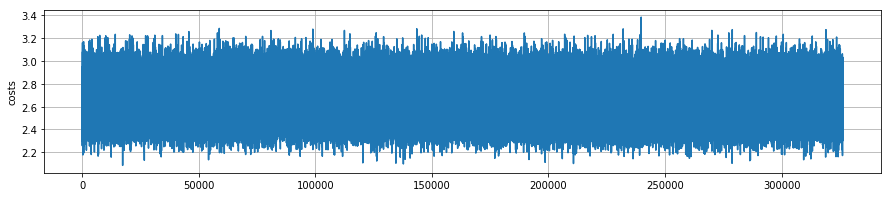

Nearest to <go>: 銘言, 成行, 報導, 驚覺, 惹, 知道, 新創, 銅鑼, 摔角, 深愛,
Nearest to 我: 他, 你, 她, 永恆, 妳, 鬆散, 立場, 她們, 我會, 卻步,
Nearest to 台灣: 日本, 美國, 女警, 據傳, 攻殼, 西班牙, 國片, 增廣見聞, 今年, 成年,
Nearest to 工作: 薪資, 心智, 處女座, 取而代之, 上班, 卍, 洗, 台達, 轉職, 街道,
Nearest to 喜歡: 討厭, 愛, 個性, 刪掉, 看準, 跳過去, 22y, 巴卡, 輕, 想要,
Nearest to 可以: 能, 能夠, 可, 崩塌, 三條, 無法, 不能, 只能, 少部分, 班底,
Nearest to 約: 每天晚上, 超過, 凹, 說原, 隨, 改天, 記念, 鮪, 雄, 聽來,
Nearest to 電影: 喜劇, 同步, 賭博, 腰身, 誰錯, 旅遊, 小說, 總結, 展覽, 49,
Nearest to 時間: 捨得, 催婚, 職業, 規畫, 瞬間, 糖果, 課, 求解, 面孔, 彼此間,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 硬要, 不容許, 呼聲, 艾蜜莉, 吹出來, 濫用,
Nearest to 閃光: 熟人, 廢話, 金鋼, 大叔, 補辦, 夫妻倆, 領獎, 離過婚, 很常, 挫折,
Nearest to <eos>: sent, 謝謝, 投球, n314, 凝視, 總評, 或是, 倘若, 萬華區, 不如意,

epoch8
Iteration  32637  ( 10.0 %) Train mean loss:  2.638799  ( std:  0.14331807 ) ; run time:  95 [s]
Iteration  65282  ( 20.0 %) Train mean loss:  2.6383033  ( std:  0.1436297 ) ; run time:  190 [s]
Iteration  97917  ( 30.0 %) Train mean loss:  2.6380253  ( std:  0.14379267 ) ; run time:  284 [s]
Iteration  130566  ( 40.0 %)

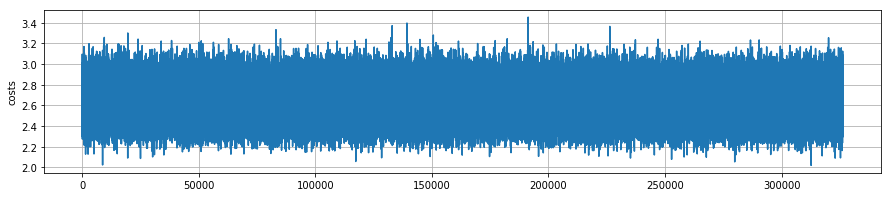

Nearest to <go>: 銘言, 報導, 成行, 知道, 驚覺, 惹, 銅鑼, 新創, 摔角, 決戰,
Nearest to 我: 他, 你, 她, 永恆, 妳, 她們, 立場, 鬆散, 我會, 抬頭,
Nearest to 台灣: 日本, 美國, 據傳, 女警, 國片, 西班牙, 攻殼, 增廣見聞, 今年, 成年,
Nearest to 工作: 薪資, 心智, 上班, 處女座, 取而代之, 卍, 台達, 轉職, 洗, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 刪掉, 看準, 22y, 巴卡, 想要, 跳過去, 輕,
Nearest to 可以: 能, 能夠, 可, 崩塌, 三條, 無法, 只能, 不能, 少部分, 班底,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 隨, 改天, 200, 鮪, 雄,
Nearest to 電影: 喜劇, 同步, 賭博, 腰身, 誰錯, 旅遊, 小說, 展覽, 49, 初一,
Nearest to 時間: 捨得, 催婚, 規畫, 職業, 瞬間, 糖果, 課, 洗個, st, 彼此間,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 呼聲, 硬要, 不容許, 艾蜜莉, 濫用, 吹出來,
Nearest to 閃光: 熟人, 廢話, 金鋼, 大叔, 補辦, 夫妻倆, 離過婚, 領獎, 很常, 轉虧,
Nearest to <eos>: sent, 謝謝, 投球, 或是, 總評, 凝視, 倘若, n314, 萬華區, 不如意,

epoch9
Iteration  32637  ( 10.0 %) Train mean loss:  2.613948  ( std:  0.14364432 ) ; run time:  92 [s]
Iteration  65270  ( 20.0 %) Train mean loss:  2.6147633  ( std:  0.14394277 ) ; run time:  186 [s]
Iteration  97919  ( 30.0 %) Train mean loss:  2.6147504  ( std:  0.1438382 ) ; run time:  279 [s]
Iteration  130556  ( 40.0 

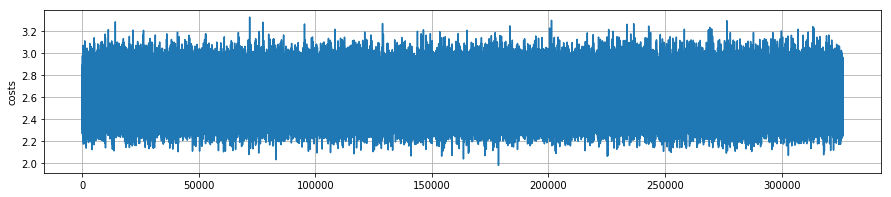

Nearest to <go>: 銘言, 報導, 成行, 知道, 驚覺, 銅鑼, 惹, 新創, 摔角, 決戰,
Nearest to 我: 他, 你, 她, 妳, 永恆, 立場, 我會, 她們, 鬆散, 我們,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 女警, 西班牙, 攻殼, 增廣見聞, 手法, 密語,
Nearest to 工作: 薪資, 上班, 心智, 取而代之, 處女座, 台達, 卍, 轉職, 洗, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 刪掉, 看準, 22y, 想要, 巴卡, 輕, 跳過去,
Nearest to 可以: 能, 能夠, 可, 崩塌, 只能, 無法, 三條, 不能, 少部分, 我會,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 200, 隨, 改天, 雄, 鮪,
Nearest to 電影: 喜劇, 同步, 賭博, 誰錯, 腰身, 展覽, 小說, 旅遊, 初一, 亞絲娜,
Nearest to 時間: 捨得, 催婚, 規畫, 職業, 瞬間, 糖果, 課, st, 聲浪, 洗個,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 呼聲, 不容許, 硬要, 濫用, 艾蜜莉, 我害,
Nearest to 閃光: 熟人, 廢話, 金鋼, 補辦, 大叔, 夫妻倆, 離過婚, 很常, 領獎, 轉虧,
Nearest to <eos>: sent, 謝謝, 或是, 投球, 總評, 倘若, 凝視, n314, 萬華區, 例如,

epoch10
Iteration  32638  ( 10.0 %) Train mean loss:  2.5943327  ( std:  0.14347434 ) ; run time:  94 [s]
Iteration  65284  ( 20.0 %) Train mean loss:  2.5955207  ( std:  0.14409322 ) ; run time:  188 [s]
Iteration  97931  ( 30.0 %) Train mean loss:  2.5954254  ( std:  0.1443315 ) ; run time:  283 [s]
Iteration  130571  ( 40.0 

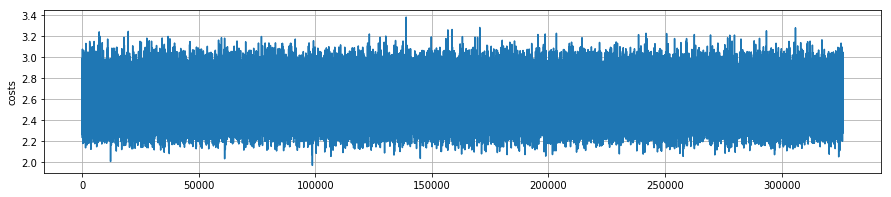

Nearest to <go>: 銘言, 報導, 成行, 知道, 銅鑼, 驚覺, 惹, 新創, 摔角, 問問,
Nearest to 我: 他, 你, 她, 妳, 永恆, 我們, 她們, 我會, 立場, 抬頭,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 西班牙, 女警, 攻殼, 增廣見聞, 手法, 密語,
Nearest to 工作: 薪資, 上班, 心智, 台達, 取而代之, 處女座, 卍, 轉職, 洗, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 刪掉, 想要, 22y, 看準, 巴卡, 輕, 常,
Nearest to 可以: 能, 能夠, 可, 崩塌, 只能, 無法, 不能, 三條, 少部分, 才能,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 200, 改天, 雄, 大約, 運氣,
Nearest to 電影: 喜劇, 同步, 誰錯, 賭博, 展覽, 腰身, 小說, 初一, 亞絲娜, 旅遊,
Nearest to 時間: 捨得, 催婚, 規畫, 職業, 瞬間, 糖果, 課, st, 隔, 聲浪,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 呼聲, 不容許, 硬要, 濫用, 我害, 艾蜜莉,
Nearest to 閃光: 熟人, 廢話, 金鋼, 補辦, 大叔, 離過婚, 夫妻倆, 很常, 轉虧, 領獎,
Nearest to <eos>: sent, 謝謝, 或是, 投球, 倘若, 總評, 凝視, 萬華區, n314, 例如,

epoch11
Iteration  32656  ( 10.0 %) Train mean loss:  2.5770667  ( std:  0.14455207 ) ; run time:  94 [s]
Iteration  65301  ( 20.0 %) Train mean loss:  2.5780196  ( std:  0.14433469 ) ; run time:  187 [s]
Iteration  97954  ( 30.0 %) Train mean loss:  2.5782452  ( std:  0.14483057 ) ; run time:  281 [s]
Iteration  130601  ( 40.0 

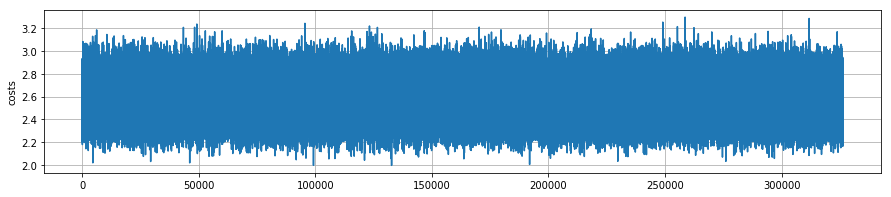

Nearest to <go>: 銘言, 報導, 成行, 知道, 銅鑼, 驚覺, 新創, 惹, 摔角, 題,
Nearest to 我: 他, 你, 她, 妳, 永恆, 我們, 我會, 立場, 她們, 抬頭,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 西班牙, 攻殼, 增廣見聞, 女警, 手法, 密語,
Nearest to 工作: 上班, 薪資, 台達, 心智, 取而代之, 卍, 轉職, 處女座, 洗, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 22y, 刪掉, 常, 輕, 看準, 流行,
Nearest to 可以: 能, 能夠, 可, 只能, 崩塌, 無法, 不能, 三條, 少部分, 才能,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 200, 大約, 改天, 運氣, 雄,
Nearest to 電影: 喜劇, 展覽, 同步, 誰錯, 賭博, 腰身, 初一, 亞絲娜, 小說, 旅遊,
Nearest to 時間: 捨得, 催婚, 規畫, 瞬間, 職業, 糖果, 課, 隔, st, 聲浪,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 呼聲, 不容許, 硬要, 濫用, 我害, 艾蜜莉,
Nearest to 閃光: 熟人, 廢話, 金鋼, 補辦, 大叔, 離過婚, 夫妻倆, 很常, 轉虧, 領獎,
Nearest to <eos>: sent, 謝謝, 或是, 投球, 總評, 倘若, 萬華區, 凝視, n314, 例如,

epoch12
Iteration  32638  ( 10.0 %) Train mean loss:  2.5609617  ( std:  0.1456066 ) ; run time:  94 [s]
Iteration  65296  ( 20.0 %) Train mean loss:  2.5611084  ( std:  0.14542782 ) ; run time:  188 [s]
Iteration  97928  ( 30.0 %) Train mean loss:  2.5621336  ( std:  0.14570348 ) ; run time:  283 [s]
Iteration  130582  ( 40.0 %)

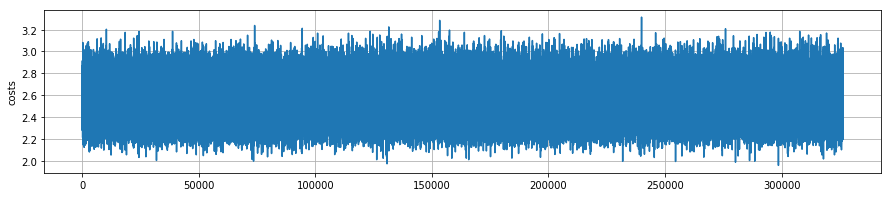

Nearest to <go>: 銘言, 報導, 成行, 知道, 銅鑼, 題, 新創, 驚覺, 摔角, 惹,
Nearest to 我: 他, 你, 她, 妳, 我們, 永恆, 我會, 立場, 她們, 抬頭,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 西班牙, 攻殼, 增廣見聞, 大陸, 手法, 臺灣,
Nearest to 工作: 上班, 薪資, 台達, 心智, 取而代之, 轉職, 卍, 處女座, 洗衣機, 洗,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 22y, 流行, 輕, 常, 刪掉, 感激,
Nearest to 可以: 能, 能夠, 可, 只能, 崩塌, 無法, 不能, 三條, 才能, 少部分,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 大約, 200, 運氣, 改天, 雄,
Nearest to 電影: 喜劇, 展覽, 誰錯, 同步, 賭博, 腰身, 初一, 亞絲娜, 動畫, 小說,
Nearest to 時間: 催婚, 捨得, 規畫, 瞬間, 職業, 糖果, 隔, 課, st, 聲浪,
Nearest to 滿足: 這還, 寫信, 為過, 我先, 呼聲, 不容許, 硬要, 濫用, 我害, 理解,
Nearest to 閃光: 熟人, 廢話, 金鋼, 補辦, 離過婚, 大叔, 夫妻倆, 轉虧, 很常, 女友,
Nearest to <eos>: sent, 謝謝, 或是, 投球, 倘若, 總評, 萬華區, 凝視, n314, 例如,

epoch13
Iteration  32649  ( 10.0 %) Train mean loss:  2.5469828  ( std:  0.14638706 ) ; run time:  94 [s]
Iteration  65294  ( 20.0 %) Train mean loss:  2.5473263  ( std:  0.14614554 ) ; run time:  188 [s]
Iteration  97929  ( 30.0 %) Train mean loss:  2.5480042  ( std:  0.14611974 ) ; run time:  283 [s]
Iteration  130570  ( 40.0 %)

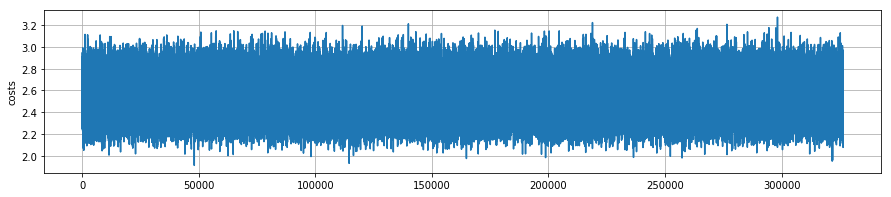

Nearest to <go>: 銘言, 報導, 成行, 知道, 題, 銅鑼, 新創, 摔角, 驚覺, 惹,
Nearest to 我: 他, 你, 她, 妳, 我們, 永恆, 我會, 小弟, 抬頭, 她們,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 西班牙, 臺灣, 大陸, 攻殼, 增廣見聞, 香港,
Nearest to 工作: 上班, 薪資, 台達, 心智, 取而代之, 轉職, 卍, 處女座, 洗衣機, 洗,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 22y, 常, 流行, 輕, 感激, 喜愛,
Nearest to 可以: 能, 能夠, 可, 只能, 崩塌, 無法, 不能, 三條, 才能, 少部分,
Nearest to 約: 超過, 每天晚上, 凹, 說原, 記念, 大約, 200, 運氣, 改天, sd,
Nearest to 電影: 喜劇, 展覽, 誰錯, 同步, 亞絲娜, 腰身, 初一, 賭博, 動畫, 小說,
Nearest to 時間: 催婚, 捨得, 規畫, 瞬間, 隔, 糖果, 課, 職業, st, 聲浪,
Nearest to 滿足: 這還, 寫信, 為過, 我先, 呼聲, 不容許, 濫用, 硬要, 我害, 理解,
Nearest to 閃光: 熟人, 廢話, 金鋼, 補辦, 離過婚, 大叔, 夫妻倆, 轉虧, 女友, 很常,
Nearest to <eos>: sent, 謝謝, 或是, 投球, 倘若, 總評, 萬華區, 凝視, 例如, n314,

epoch14
Iteration  32636  ( 10.0 %) Train mean loss:  2.5352488  ( std:  0.14663208 ) ; run time:  94 [s]
Iteration  65272  ( 20.0 %) Train mean loss:  2.5353582  ( std:  0.14644632 ) ; run time:  188 [s]
Iteration  97911  ( 30.0 %) Train mean loss:  2.5358942  ( std:  0.14628303 ) ; run time:  283 [s]
Iteration  130543  ( 40.0 %

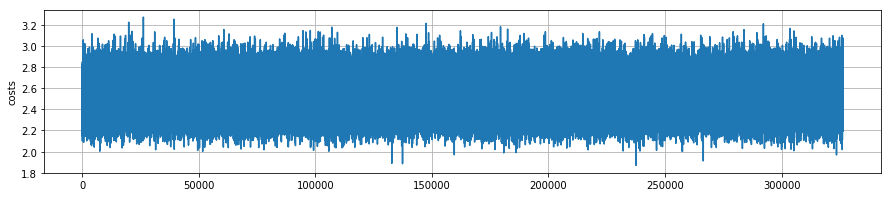

Nearest to <go>: 銘言, 報導, 題, 成行, 知道, 銅鑼, 新創, 驚覺, 摔角, 問問,
Nearest to 我: 他, 你, 她, 妳, 我們, 永恆, 我會, 小弟, 抬頭, 她們,
Nearest to 台灣: 日本, 美國, 據傳, 國片, 臺灣, 西班牙, 大陸, 攻殼, 香港, 增廣見聞,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 心智, 轉職, 卍, 處女座, 洗衣機, 洗,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 22y, 流行, 常, 喜愛, 輕, 排斥,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 崩塌, 不能, 三條, 才能, 少部分,
Nearest to 約: 超過, 每天晚上, 凹, 大約, 記念, 說原, 200, 運氣, sd, 改天,
Nearest to 電影: 喜劇, 展覽, 誰錯, 同步, 動畫, 初一, 亞絲娜, 腰身, 賭博, 漫畫,
Nearest to 時間: 捨得, 催婚, 規畫, 隔, 瞬間, 課, 糖果, st, 聲浪, 職業,
Nearest to 滿足: 這還, 寫信, 我先, 為過, 呼聲, 不容許, 濫用, 我害, 理解, 硬要,
Nearest to 閃光: 熟人, 廢話, 金鋼, 離過婚, 補辦, 夫妻倆, 大叔, 女友, 轉虧, 很常,
Nearest to <eos>: sent, 或是, 謝謝, 投球, 倘若, 總評, 萬華區, 凝視, 例如, n314,

epoch15
Iteration  32644  ( 10.0 %) Train mean loss:  2.5238457  ( std:  0.14706 ) ; run time:  94 [s]
Iteration  65276  ( 20.0 %) Train mean loss:  2.524562  ( std:  0.14653951 ) ; run time:  189 [s]
Iteration  97924  ( 30.0 %) Train mean loss:  2.524186  ( std:  0.14657345 ) ; run time:  283 [s]
Iteration  130562  ( 40.0 %) Tr

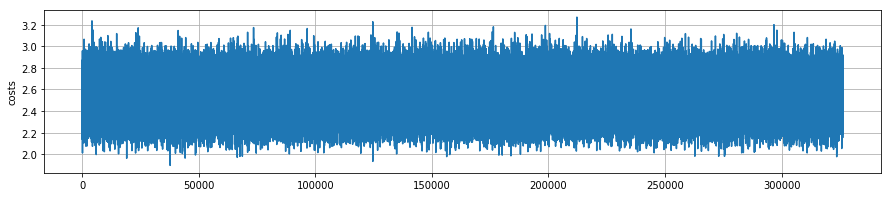

Nearest to <go>: 銘言, 報導, 題, 知道, 成行, 銅鑼, 摔角, 新創, 驚覺, 問問,
Nearest to 我: 他, 你, 她, 妳, 我們, 永恆, 小弟, 我會, 抬頭, 不對勁,
Nearest to 台灣: 日本, 美國, 據傳, 臺灣, 大陸, 國片, 西班牙, 香港, 攻殼, 韓國,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 心智, 轉職, 卍, 處女座, 正職, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 流行, 22y, 常, 喜愛, 排斥, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 崩塌, 不能, 才能, 三條, 會,
Nearest to 約: 超過, 每天晚上, 凹, 大約, 記念, 說原, 200, 運氣, sd, 改天,
Nearest to 電影: 喜劇, 展覽, 誰錯, 動畫, 同步, 亞絲娜, 初一, 漫畫, 腰身, 賭博,
Nearest to 時間: 捨得, 催婚, 規畫, 隔, 瞬間, st, 聲浪, 課, 糖果, 鎖門,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 不容許, 濫用, 理解, 我害, 硬要,
Nearest to 閃光: 熟人, 廢話, 金鋼, 離過婚, 女友, 補辦, 夫妻倆, 大叔, 轉虧, 很常,
Nearest to <eos>: sent, 或是, 謝謝, 投球, 倘若, 總評, 萬華區, 例如, 啾, 凝視,

epoch16
Iteration  32657  ( 10.0 %) Train mean loss:  2.511822  ( std:  0.14543271 ) ; run time:  94 [s]
Iteration  65287  ( 20.0 %) Train mean loss:  2.513126  ( std:  0.1458851 ) ; run time:  189 [s]
Iteration  97923  ( 30.0 %) Train mean loss:  2.5134952  ( std:  0.14635614 ) ; run time:  283 [s]
Iteration  130553  ( 40.0 %) Train

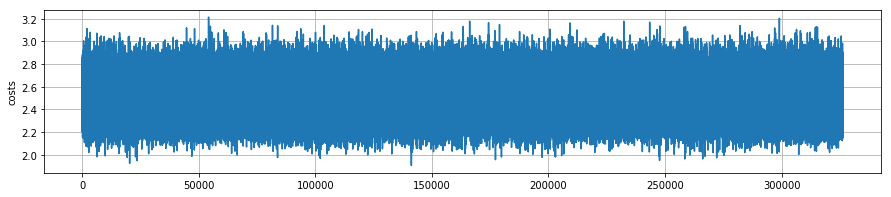

Nearest to <go>: 銘言, 報導, 題, 知道, 成行, 銅鑼, 摔角, 新創, 問問, 驚覺,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 永恆, 抬頭, 不對勁,
Nearest to 台灣: 日本, 美國, 臺灣, 據傳, 大陸, 國片, 西班牙, 香港, 韓國, 攻殼,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 心智, 轉職, 卍, 處女座, 正職, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 想要, 流行, 喜愛, 22y, 常, 排斥, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 崩塌, 不能, 才能, 願意, 三條,
Nearest to 約: 超過, 每天晚上, 大約, 凹, 記念, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 誰錯, 動畫, 亞絲娜, 初一, 漫畫, 同步, 腰身, 日劇,
Nearest to 時間: 捨得, 催婚, 規畫, 隔, 瞬間, 聲浪, st, 課, 糖果, 鎖門,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 不容許, 濫用, 理解, 我害, 硬要,
Nearest to 閃光: 熟人, 金鋼, 廢話, 女友, 離過婚, 補辦, 夫妻倆, 轉虧, 大叔, 很常,
Nearest to <eos>: sent, 或是, 謝謝, 投球, 倘若, 總評, 萬華區, 啾, 例如, 作答,

epoch17
Iteration  32637  ( 10.0 %) Train mean loss:  2.5027869  ( std:  0.14688821 ) ; run time:  94 [s]
Iteration  65272  ( 20.0 %) Train mean loss:  2.5030518  ( std:  0.14758502 ) ; run time:  189 [s]
Iteration  97923  ( 30.0 %) Train mean loss:  2.5032904  ( std:  0.14736053 ) ; run time:  283 [s]
Iteration  130550  ( 40.0 %) T

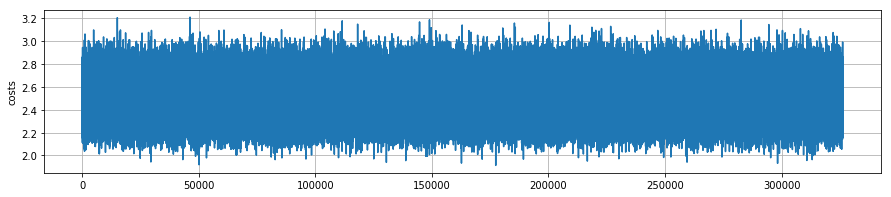

Nearest to <go>: 銘言, 報導, 題, 成行, 知道, 銅鑼, 問問, 新創, 摔角, 驚覺,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 永恆, 抬頭, 她則,
Nearest to 台灣: 日本, 美國, 臺灣, 大陸, 據傳, 國片, 西班牙, 韓國, 香港, 攻殼,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 心智, 轉職, 卍, 正職, 處女座, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 喜愛, 想要, 流行, 排斥, 22y, 常, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 崩塌, 不能, 才能, 願意, 要,
Nearest to 約: 超過, 大約, 每天晚上, 凹, 記念, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 誰錯, 動畫, 漫畫, 初一, 亞絲娜, 同步, 日劇, 腰身,
Nearest to 時間: 捨得, 催婚, 規畫, 隔, 瞬間, 聲浪, 鎖門, st, 課, 糖果,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 理解, 不容許, 濫用, 我害, 硬要,
Nearest to 閃光: 熟人, 金鋼, 廢話, 女友, 離過婚, 補辦, 夫妻倆, 轉虧, 男友, 大叔,
Nearest to <eos>: sent, 或是, 謝謝, 投球, 倘若, 總評, 萬華區, 啾, 例如, 作答,

epoch18
Iteration  32653  ( 10.0 %) Train mean loss:  2.492357  ( std:  0.14668198 ) ; run time:  94 [s]
Iteration  65288  ( 20.0 %) Train mean loss:  2.4937015  ( std:  0.14685851 ) ; run time:  188 [s]
Iteration  97929  ( 30.0 %) Train mean loss:  2.4942925  ( std:  0.14688236 ) ; run time:  282 [s]
Iteration  130549  ( 40.0 %) Trai

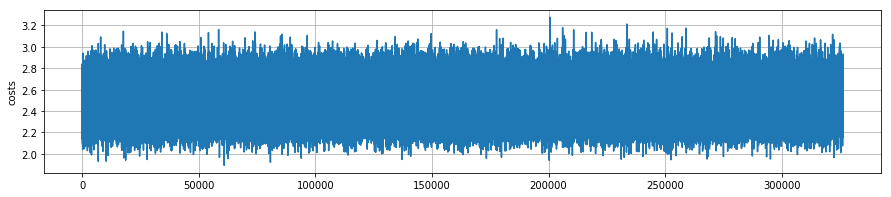

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 銅鑼, 摔角, 問問, 新創, 鬼神,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 永恆, 不對勁, 她則,
Nearest to 台灣: 日本, 美國, 臺灣, 大陸, 據傳, 國片, 韓國, 西班牙, 香港, 攻殼,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 轉職, 心智, 卍, 正職, 處女座, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 個性, 喜愛, 想要, 流行, 排斥, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 崩塌, 不能, 才能, 願意, 會,
Nearest to 約: 超過, 大約, 每天晚上, 凹, 記念, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 動畫, 誰錯, 漫畫, 初一, 亞絲娜, 日劇, 同步, 大作,
Nearest to 時間: 捨得, 催婚, 規畫, 隔, 瞬間, 鎖門, 聲浪, st, 課, 糖果,
Nearest to 滿足: 這還, 我先, 為過, 寫信, 呼聲, 理解, 不容許, 濫用, 我害, 硬要,
Nearest to 閃光: 熟人, 金鋼, 廢話, 女友, 離過婚, 男友, 補辦, 夫妻倆, 轉虧, 大叔,
Nearest to <eos>: sent, 或是, 投球, 謝謝, 倘若, 總評, 萬華區, 啾, 例如, 作答,

epoch19
Iteration  32628  ( 10.0 %) Train mean loss:  2.4846196  ( std:  0.14706406 ) ; run time:  93 [s]
Iteration  65275  ( 20.0 %) Train mean loss:  2.4849665  ( std:  0.1474274 ) ; run time:  187 [s]
Iteration  97930  ( 30.0 %) Train mean loss:  2.4853513  ( std:  0.14747663 ) ; run time:  281 [s]
Iteration  130561  ( 40.0 %) Tra

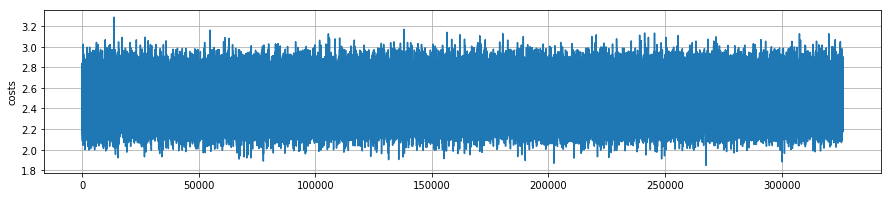

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 銅鑼, 問問, 鬼神, 摔角, 新創,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 永恆, 不對勁, 他們,
Nearest to 台灣: 日本, 美國, 臺灣, 大陸, 韓國, 據傳, 國片, 西班牙, 香港, 高雄,
Nearest to 工作: 上班, 薪資, 台達, 取而代之, 轉職, 心智, 卍, 正職, 處女座, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 喜愛, 個性, 排斥, 想要, 流行, 22y, 常, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 崩塌, 才能, 願意, 要,
Nearest to 約: 超過, 大約, 每天晚上, 記念, 凹, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 動畫, 誰錯, 漫畫, 初一, 亞絲娜, 日劇, 大作, 片,
Nearest to 時間: 捨得, 催婚, 隔, 規畫, 瞬間, 鎖門, 聲浪, st, 課, 糖果,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 理解, 濫用, 不容許, 我害, 硬要,
Nearest to 閃光: 熟人, 金鋼, 廢話, 女友, 離過婚, 男友, 補辦, 夫妻倆, 轉虧, 她,
Nearest to <eos>: sent, 或是, 謝謝, 投球, 倘若, 總評, 萬華區, 啾, 作答, 例如,

epoch20
Iteration  32654  ( 10.0 %) Train mean loss:  2.473816  ( std:  0.14756556 ) ; run time:  94 [s]
Iteration  65291  ( 20.0 %) Train mean loss:  2.4762983  ( std:  0.14846998 ) ; run time:  189 [s]
Iteration  97920  ( 30.0 %) Train mean loss:  2.4773939  ( std:  0.14814235 ) ; run time:  284 [s]
Iteration  130557  ( 40.0 %) Train

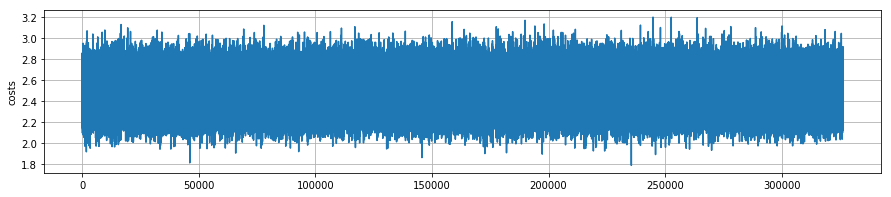

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 銅鑼, 鬼神, 問問, 摔角, 新創,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 不對勁, 永恆, 她則,
Nearest to 台灣: 日本, 臺灣, 美國, 大陸, 韓國, 據傳, 國片, 香港, 西班牙, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 卍, 正職, 處女座, 洗衣機,
Nearest to 喜歡: 討厭, 愛, 喜愛, 想要, 排斥, 個性, 流行, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 崩塌, 才能, 願意, 要,
Nearest to 約: 超過, 大約, 每天晚上, 記念, 凹, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 誰錯, 日劇, 初一, 亞絲娜, 大作, 片,
Nearest to 時間: 捨得, 催婚, 隔, 規畫, 瞬間, 鎖門, st, 聲浪, 課, 糖果,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 理解, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 金鋼, 廢話, 女友, 男友, 離過婚, 她, 夫妻倆, 補辦, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 謝謝, 倘若, 總評, 萬華區, 啾, 作答, 例如,

epoch21
Iteration  32647  ( 10.0 %) Train mean loss:  2.4691224  ( std:  0.14837644 ) ; run time:  94 [s]
Iteration  65300  ( 20.0 %) Train mean loss:  2.4702344  ( std:  0.14829862 ) ; run time:  188 [s]
Iteration  97934  ( 30.0 %) Train mean loss:  2.4708407  ( std:  0.14836955 ) ; run time:  282 [s]
Iteration  130577  ( 40.0 %) Trai

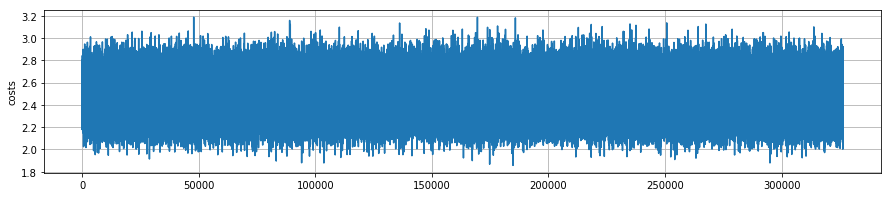

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 銅鑼, 問問, 鬼神, 摔角, 王妃,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 我會, 不對勁, 她則, 永恆,
Nearest to 台灣: 日本, 臺灣, 美國, 大陸, 韓國, 據傳, 香港, 國片, 西班牙, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 卍, 正職, 處女座, 越會,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 個性, 流行, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 崩塌, 願意, 才能, 會,
Nearest to 約: 超過, 大約, 記念, 每天晚上, 凹, 說原, 200, sd, 運氣, 改天,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 誰錯, 日劇, 大作, 亞絲娜, 初一, 片,
Nearest to 時間: 捨得, 催婚, 隔, 瞬間, 規畫, 鎖門, 聲浪, st, 課, 糖果,
Nearest to 滿足: 這還, 我先, 寫信, 為過, 呼聲, 理解, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 金鋼, 女友, 廢話, 男友, 離過婚, 她, 夫妻倆, 補辦, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 謝謝, 倘若, 總評, 萬華區, 啾, 作答, 不簽,

epoch22
Iteration  32643  ( 10.0 %) Train mean loss:  2.4610004  ( std:  0.14734152 ) ; run time:  94 [s]
Iteration  65294  ( 20.0 %) Train mean loss:  2.4622939  ( std:  0.14764972 ) ; run time:  188 [s]
Iteration  97932  ( 30.0 %) Train mean loss:  2.4638426  ( std:  0.14785783 ) ; run time:  282 [s]
Iteration  130579  ( 40.0 %) Train

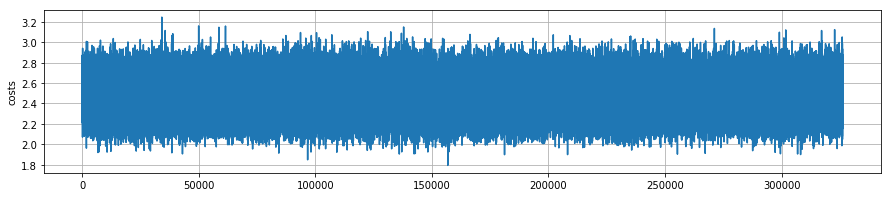

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 銅鑼, 問問, 鬼神, 摔角, 新創,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 我會, 她則, 永恆,
Nearest to 台灣: 日本, 臺灣, 美國, 韓國, 大陸, 據傳, 香港, 國片, 西班牙, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 處女座, 越會,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 願意, 才能, 崩塌, 會,
Nearest to 約: 超過, 大約, 記念, 每天晚上, 說原, 凹, 200, sd, 運氣, 初次,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 誰錯, 日劇, 大作, 片, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 隔, 瞬間, 規畫, 鎖門, st, 聲浪, 日期, 會心,
Nearest to 滿足: 這還, 我先, 呼聲, 寫信, 為過, 理解, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 金鋼, 女友, 男友, 廢話, 她, 離過婚, 夫妻倆, 補辦, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 總評, 萬華區, 啾, 作答, 不簽,

epoch23
Iteration  32643  ( 10.0 %) Train mean loss:  2.4542048  ( std:  0.14782758 ) ; run time:  94 [s]
Iteration  65284  ( 20.0 %) Train mean loss:  2.4552395  ( std:  0.14788803 ) ; run time:  188 [s]
Iteration  97910  ( 30.0 %) Train mean loss:  2.4563317  ( std:  0.14844108 ) ; run time:  283 [s]
Iteration  130545  ( 40.0 %) Trai

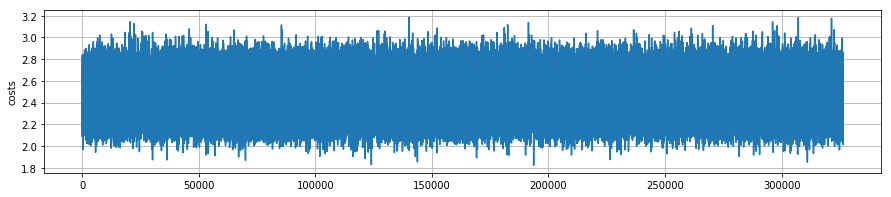

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 銅鑼, 鬼神, 問問, 摔角, 王妃,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 我會, 永恆,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 國片, 西班牙, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 處女座,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 個性, 流行, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 願意, 才能, 崩塌, 會,
Nearest to 約: 大約, 超過, 記念, 每天晚上, 說原, 凹, 200, sd, 運氣, 初次,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 誰錯, 大作, 日劇, 片, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 隔, 鎖門, 瞬間, 規畫, st, 聲浪, 日期, 彈幕,
Nearest to 滿足: 我先, 這還, 呼聲, 寫信, 為過, 理解, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 金鋼, 女友, 男友, 她, 廢話, 離過婚, 夫妻倆, 補辦, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 總評, 萬華區, 啾, 作答, 之類,

epoch24
Iteration  32641  ( 10.0 %) Train mean loss:  2.4481103  ( std:  0.1480533 ) ; run time:  94 [s]
Iteration  65286  ( 20.0 %) Train mean loss:  2.4496331  ( std:  0.14753166 ) ; run time:  188 [s]
Iteration  97927  ( 30.0 %) Train mean loss:  2.4502587  ( std:  0.14784822 ) ; run time:  282 [s]
Iteration  130569  ( 40.0 %) Train

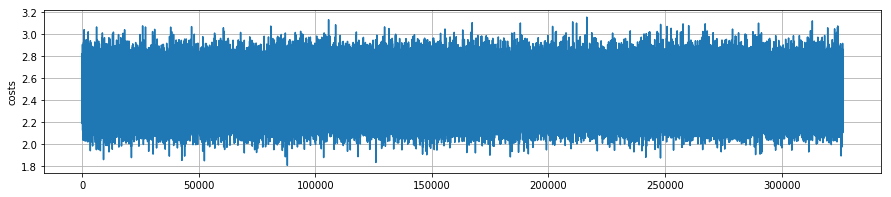

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 銅鑼, 問問, 鬼神, 摔角, 王妃,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 我會, 他們,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 福利,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 常, 22y, 輕,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 願意, 才能, 崩塌, 還能,
Nearest to 約: 大約, 超過, 記念, 每天晚上, 說原, 凹, 200, sd, 運氣, 初次,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 誰錯, 日劇, 亞絲娜, 片, 初一,
Nearest to 時間: 捨得, 催婚, 隔, 鎖門, 瞬間, 規畫, st, 聲浪, 日期, 彈幕,
Nearest to 滿足: 我先, 這還, 呼聲, 寫信, 理解, 為過, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 金鋼, 女友, 男友, 她, 廢話, 離過婚, 夫妻倆, 轉虧, 補辦,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 總評, 萬華區, 之類, 啾, 作答,

epoch25
Iteration  32633  ( 10.0 %) Train mean loss:  2.4442234  ( std:  0.14676094 ) ; run time:  93 [s]
Iteration  65276  ( 20.0 %) Train mean loss:  2.4442105  ( std:  0.14797209 ) ; run time:  187 [s]
Iteration  97917  ( 30.0 %) Train mean loss:  2.4452271  ( std:  0.14882216 ) ; run time:  281 [s]
Iteration  130566  ( 40.0 %) Trai

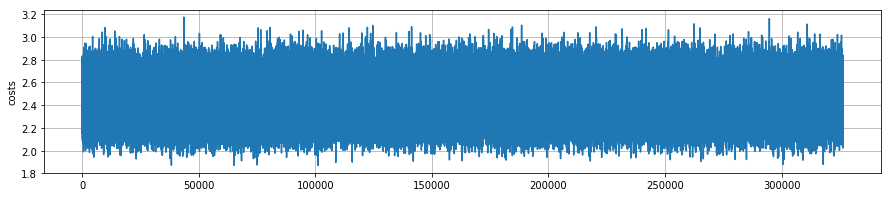

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 問問, 王妃, 摔角,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 福利,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 常, 22y, 感激,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 願意, 才能, 崩塌, 還能,
Nearest to 約: 大約, 超過, 記念, 每天晚上, 說原, 凹, sd, 200, 運氣, 初次,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 誰錯, 片, 日劇, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 鎖門, 瞬間, 隔, 規畫, 日期, st, 聲浪, 彈幕,
Nearest to 滿足: 我先, 這還, 呼聲, 理解, 寫信, 為過, 濫用, 不容許, 我害, 相較,
Nearest to 閃光: 熟人, 男友, 女友, 金鋼, 她, 廢話, 離過婚, 夫妻倆, 轉虧, 他,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 總評, 萬華區, 之類, 作答, 啾,

epoch26
Iteration  32636  ( 10.0 %) Train mean loss:  2.4369564  ( std:  0.1496223 ) ; run time:  90 [s]
Iteration  65261  ( 20.0 %) Train mean loss:  2.4379375  ( std:  0.14882936 ) ; run time:  181 [s]
Iteration  97915  ( 30.0 %) Train mean loss:  2.4387186  ( std:  0.14880756 ) ; run time:  272 [s]
Iteration  130554  ( 40.0 %) Train

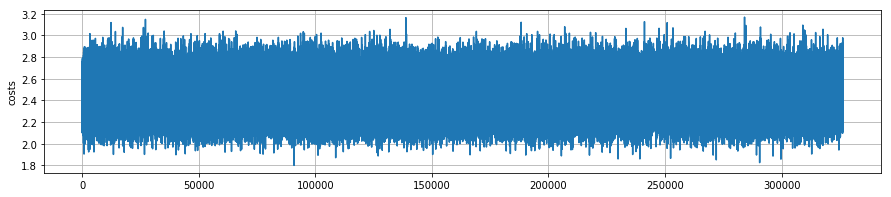

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 問問, 王妃, 摔角,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 篇章,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 常, 22y, 熱愛,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 不能, 願意, 才能, 還能, 要,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, 凹, sd, 200, 初次, 運氣,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 日劇, 誰錯, 片, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 鎖門, 瞬間, 日期, 隔, 規畫, 聲浪, st, 彈幕,
Nearest to 滿足: 我先, 這還, 呼聲, 理解, 寫信, 濫用, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 熟人, 金鋼, 她, 離過婚, 廢話, 他, 夫妻倆, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 總評, 之類, 萬華區, 作答, 啾,

epoch27
Iteration  32637  ( 10.0 %) Train mean loss:  2.4303408  ( std:  0.14798605 ) ; run time:  91 [s]
Iteration  65278  ( 20.0 %) Train mean loss:  2.431727  ( std:  0.14836918 ) ; run time:  182 [s]
Iteration  97929  ( 30.0 %) Train mean loss:  2.4330525  ( std:  0.1481878 ) ; run time:  273 [s]
Iteration  130558  ( 40.0 %) Train m

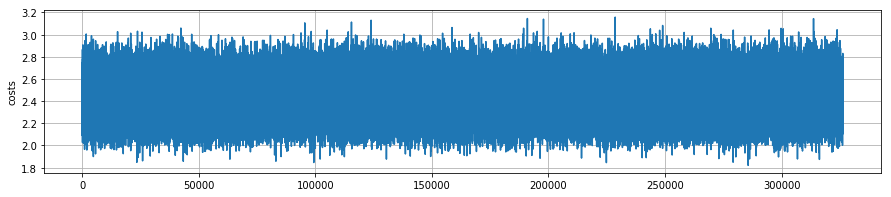

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 鬼神, 銅鑼, 問問, 王妃, 摔角,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 篇章,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 常, 22y, 熱愛,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 願意, 不能, 才能, 還能, 要,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, 凹, sd, 200, 初次, 運氣,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 片, 誰錯, 日劇, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 鎖門, 瞬間, 日期, 隔, 規畫, 聲浪, st, 彈幕,
Nearest to 滿足: 我先, 這還, 呼聲, 理解, 濫用, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 金鋼, 熟人, 她, 離過婚, 廢話, 他, 夫妻倆, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 之類, 帶來, 作答, 萬華區, 總評,

epoch28
Iteration  32623  ( 10.0 %) Train mean loss:  2.4262369  ( std:  0.14804529 ) ; run time:  90 [s]
Iteration  65270  ( 20.0 %) Train mean loss:  2.4277475  ( std:  0.14839464 ) ; run time:  181 [s]
Iteration  97917  ( 30.0 %) Train mean loss:  2.4284186  ( std:  0.14843386 ) ; run time:  273 [s]
Iteration  130553  ( 40.0 %) Trai

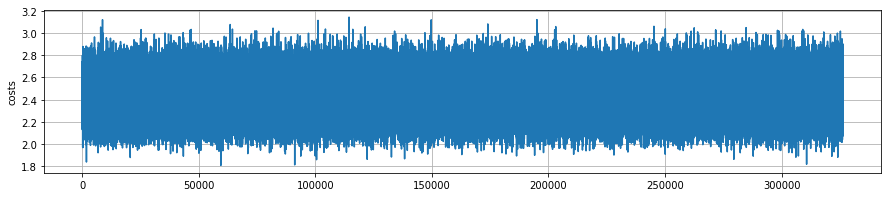

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 鬼神, 銅鑼, 問問, 王妃, 半顆,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 我會, 他們,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 高雄,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 職務,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 流行, 個性, 22y, 常, 熱愛,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 願意, 不能, 還能, 才能, 要,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, 凹, sd, 200, 初次, 運氣,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 日劇, 片, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 鎖門, 日期, 瞬間, 規畫, 隔, st, 聲浪, 彈幕,
Nearest to 滿足: 我先, 呼聲, 理解, 這還, 濫用, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 她, 金鋼, 熟人, 離過婚, 廢話, 他, 夫妻倆, 轉虧,
Nearest to <eos>: sent, 或是, 投球, 倘若, 謝謝, 帶來, 之類, 萬華區, 作答, 啾,

epoch29
Iteration  32638  ( 10.0 %) Train mean loss:  2.421873  ( std:  0.14895426 ) ; run time:  90 [s]
Iteration  65287  ( 20.0 %) Train mean loss:  2.4236572  ( std:  0.14878891 ) ; run time:  182 [s]
Iteration  97929  ( 30.0 %) Train mean loss:  2.4240906  ( std:  0.14895411 ) ; run time:  273 [s]
Iteration  130576  ( 40.0 %) Train 

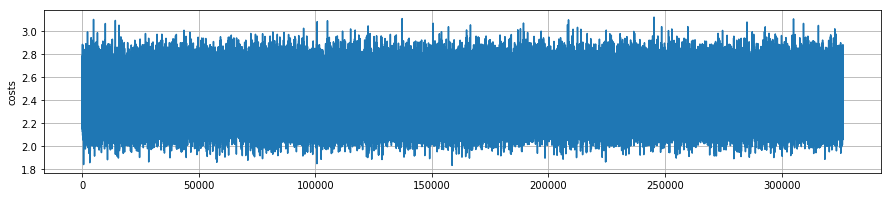

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 摔角,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 美國, 香港, 據傳, 西班牙, 國片, 中國,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 卍, 越會, 職務,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 個性, 流行, 常, 22y, 熱愛,
Nearest to 可以: 能夠, 能, 可, 只能, 無法, 願意, 不能, 還能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, 凹, sd, 初次, 200, 歷年,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 日劇, 片, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 鎖門, 日期, 瞬間, 規畫, 隔, 聲浪, 彈幕, st,
Nearest to 滿足: 我先, 呼聲, 理解, 這還, 濫用, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 她, 金鋼, 熟人, 離過婚, 他, 廢話, 夫妻倆, 老公,
Nearest to <eos>: sent, 或是, 倘若, 投球, 謝謝, 帶來, 之類, 作答, 萬華區, 啾,

epoch30
Iteration  32634  ( 10.0 %) Train mean loss:  2.4173584  ( std:  0.14950867 ) ; run time:  90 [s]
Iteration  65291  ( 20.0 %) Train mean loss:  2.4180744  ( std:  0.14844647 ) ; run time:  181 [s]
Iteration  97942  ( 30.0 %) Train mean loss:  2.418758  ( std:  0.1483818 ) ; run time:  273 [s]
Iteration  130577  ( 40.0 %) Train m

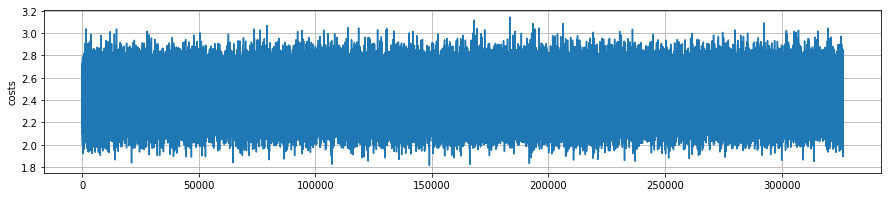

Nearest to <go>: 銘言, 題, 報導, 成行, 知道, 鬼神, 銅鑼, 王妃, 問問, 摔角,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 國片, 中國,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 越會, 卍, 職務,
Nearest to 喜歡: 討厭, 愛, 喜愛, 排斥, 想要, 個性, 流行, 22y, 常, 熱愛,
Nearest to 可以: 能夠, 能, 可, 只能, 無法, 願意, 不能, 還能, 才能, 要,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, sd, 凹, 初次, 200, 歷年,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 片, 日劇, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 日期, 鎖門, 瞬間, 彈幕, 規畫, 隔, 聲浪, 聊個,
Nearest to 滿足: 我先, 理解, 呼聲, 濫用, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 她, 金鋼, 熟人, 離過婚, 他, 廢話, 老公, 夫妻倆,
Nearest to <eos>: sent, 或是, 倘若, 投球, 謝謝, 之類, 帶來, 作答, 啾, 總評,

epoch31
Iteration  32634  ( 10.0 %) Train mean loss:  2.4118001  ( std:  0.14859603 ) ; run time:  90 [s]
Iteration  65274  ( 20.0 %) Train mean loss:  2.4130526  ( std:  0.14860564 ) ; run time:  181 [s]
Iteration  97909  ( 30.0 %) Train mean loss:  2.413684  ( std:  0.14891355 ) ; run time:  272 [s]
Iteration  130545  ( 40.0 %) Train m

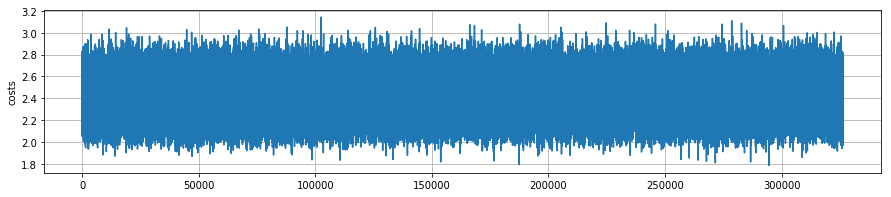

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 半顆,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 大心,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 國片, 中國,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 越會, 卍, 職務,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 流行, 熱愛, 常, 22y,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 願意, 還能, 不能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, sd, 凹, 初次, 200, 歷年,
Nearest to 電影: 喜劇, 動畫, 展覽, 漫畫, 大作, 片, 日劇, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 日期, 鎖門, 瞬間, 彈幕, 隔, 聊個, st, 聲浪,
Nearest to 滿足: 我先, 理解, 呼聲, 濫用, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 離過婚, 他, 廢話, 老公, 夫妻倆,
Nearest to <eos>: sent, 或是, 倘若, 投球, 之類, 謝謝, 帶來, 作答, 總評, 啾,

epoch32
Iteration  32627  ( 10.0 %) Train mean loss:  2.4073453  ( std:  0.14922345 ) ; run time:  91 [s]
Iteration  65280  ( 20.0 %) Train mean loss:  2.408319  ( std:  0.14934339 ) ; run time:  181 [s]
Iteration  97938  ( 30.0 %) Train mean loss:  2.4095168  ( std:  0.14936274 ) ; run time:  272 [s]
Iteration  130587  ( 40.0 %) Train m

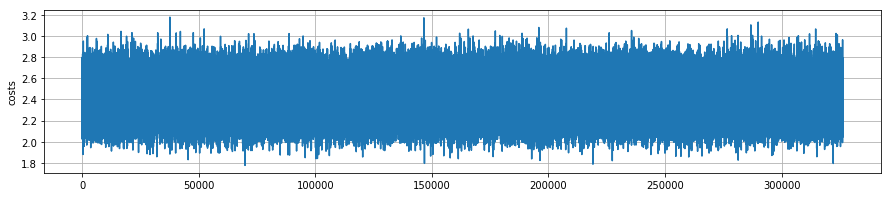

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 半顆,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 她則, 他們, 我會,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 國片, 中國,
Nearest to 工作: 上班, 台達, 薪資, 取而代之, 轉職, 心智, 正職, 越會, 職務, 卍,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 流行, 熱愛, 常, 22y,
Nearest to 可以: 能, 能夠, 可, 只能, 無法, 還能, 願意, 不能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, sd, 初次, 200, 凹, 歷年,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 片, 日劇, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 催婚, 日期, 鎖門, 瞬間, 彈幕, 聊個, 規畫, st, 隔,
Nearest to 滿足: 我先, 理解, 呼聲, 濫用, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 離過婚, 他, 廢話, 老公, 轉虧,
Nearest to <eos>: sent, 或是, 倘若, 投球, 帶來, 之類, 謝謝, 作答, 啾, 總評,

epoch33
Iteration  32643  ( 10.0 %) Train mean loss:  2.4038968  ( std:  0.14980993 ) ; run time:  93 [s]
Iteration  65291  ( 20.0 %) Train mean loss:  2.4051201  ( std:  0.14956558 ) ; run time:  187 [s]
Iteration  97933  ( 30.0 %) Train mean loss:  2.4055543  ( std:  0.14933528 ) ; run time:  281 [s]
Iteration  130574  ( 40.0 %) Train m

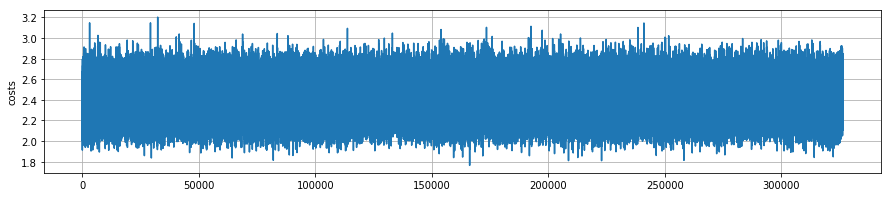

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 半顆,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 本魯,
Nearest to 台灣: 日本, 臺灣, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 國片, 中國,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 轉職, 心智, 正職, 越會, 職務, 卍,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 流行, 熱愛, 22y, 常,
Nearest to 可以: 能夠, 能, 可, 只能, 無法, 還能, 願意, 不能, 才能, 要,
Nearest to 約: 大約, 超過, 記念, 說原, 每天晚上, 初次, sd, 歷年, 200, 凹,
Nearest to 電影: 喜劇, 展覽, 動畫, 漫畫, 大作, 日劇, 片, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 瞬間, 彈幕, 聊個, 隔, st, 聲浪,
Nearest to 滿足: 我先, 理解, 呼聲, 濫用, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 女友, 她, 金鋼, 熟人, 離過婚, 他, 廢話, 老公, 另一半,
Nearest to <eos>: sent, 或是, 倘若, 投球, 帶來, 之類, 謝謝, 作答, 總評, 啾,

epoch34
Iteration  32628  ( 10.0 %) Train mean loss:  2.4002018  ( std:  0.14881933 ) ; run time:  93 [s]
Iteration  65260  ( 20.0 %) Train mean loss:  2.4009361  ( std:  0.14864515 ) ; run time:  187 [s]
Iteration  97897  ( 30.0 %) Train mean loss:  2.4016097  ( std:  0.14854512 ) ; run time:  281 [s]
Iteration  130544  ( 40.0 %) Train 

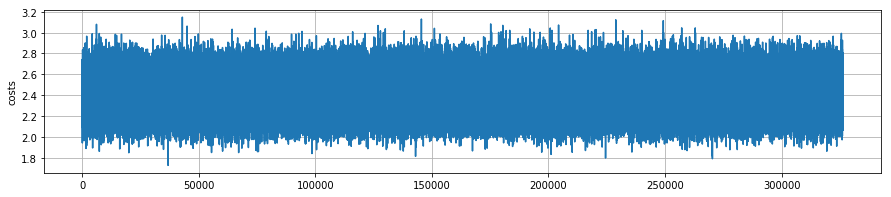

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 追緝,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 不對勁, 她則, 他們, 本魯,
Nearest to 台灣: 臺灣, 日本, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 轉職, 心智, 正職, 越會, 職務, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 流行, 熱愛, 常, 22y,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 無法, 願意, 不能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 初次, 每天晚上, sd, 200, 歷年, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 漫畫, 大作, 日劇, 片, 誰錯, 亞絲娜, 初一,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 瞬間, 彈幕, 聊個, 壓根, st, 聲浪,
Nearest to 滿足: 我先, 理解, 呼聲, 濫用, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 老公, 廢話, 另一半,
Nearest to <eos>: sent, 或是, 倘若, 投球, 帶來, 之類, 謝謝, 作答, 啾, 總評,

epoch35
Iteration  32642  ( 10.0 %) Train mean loss:  2.3956995  ( std:  0.15043616 ) ; run time:  93 [s]
Iteration  65285  ( 20.0 %) Train mean loss:  2.3964806  ( std:  0.14981058 ) ; run time:  187 [s]
Iteration  97936  ( 30.0 %) Train mean loss:  2.397255  ( std:  0.14983353 ) ; run time:  283 [s]
Iteration  130573  ( 40.0 %) Train

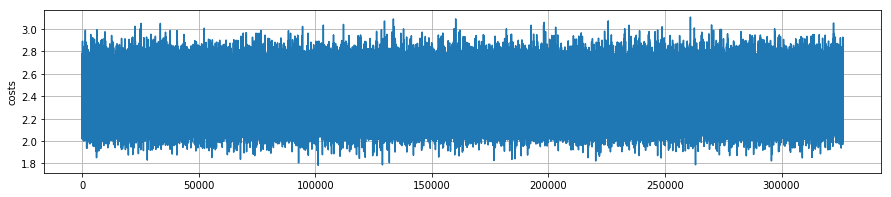

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 問問, 追緝,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 她則, 他們, 本魯,
Nearest to 台灣: 臺灣, 日本, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 轉職, 心智, 正職, 越會, 職務, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 流行, 熱愛, 常, 22y,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 無法, 不能, 願意, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 初次, sd, 每天晚上, 歷年, 200, 凹,
Nearest to 電影: 喜劇, 展覽, 動畫, 大作, 漫畫, 日劇, 片, 新片, 亞絲娜, 誰錯,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 瞬間, 彈幕, 聊個, 壓根, st, 會心,
Nearest to 滿足: 我先, 理解, 濫用, 呼聲, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 老公, 另一半, 廢話,
Nearest to <eos>: sent, 或是, 倘若, 帶來, 投球, 之類, 謝謝, 作答, 啾, be,

epoch36
Iteration  32638  ( 10.0 %) Train mean loss:  2.3929594  ( std:  0.14960638 ) ; run time:  93 [s]
Iteration  65272  ( 20.0 %) Train mean loss:  2.3935716  ( std:  0.1487706 ) ; run time:  187 [s]
Iteration  97907  ( 30.0 %) Train mean loss:  2.3938425  ( std:  0.14877817 ) ; run time:  280 [s]
Iteration  130561  ( 40.0 %) Train

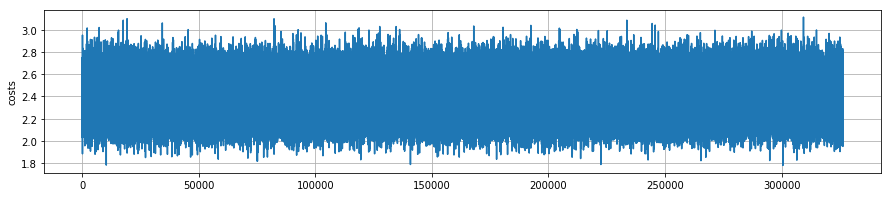

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 半顆, 問問,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 她則, 本魯, 他們,
Nearest to 台灣: 臺灣, 日本, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 正職, 轉職, 心智, 越會, 職務, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 個性, 熱愛, 流行, 常, 22y,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 無法, 願意, 不能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 初次, sd, 每天晚上, 歷年, 200, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 漫畫, 大作, 日劇, 片, 新片, 誰錯, 亞絲娜,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 瞬間, 彈幕, 聊個, 壓根, st, 會心,
Nearest to 滿足: 我先, 理解, 濫用, 呼聲, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 另一半, 老公, 廢話,
Nearest to <eos>: sent, 或是, 倘若, 帶來, 之類, 投球, 謝謝, be, 作答, 啾,

epoch37
Iteration  32650  ( 10.0 %) Train mean loss:  2.3880923  ( std:  0.14885733 ) ; run time:  93 [s]
Iteration  65287  ( 20.0 %) Train mean loss:  2.3896945  ( std:  0.14915621 ) ; run time:  187 [s]
Iteration  97922  ( 30.0 %) Train mean loss:  2.390565  ( std:  0.14943393 ) ; run time:  281 [s]
Iteration  130567  ( 40.0 %) Train

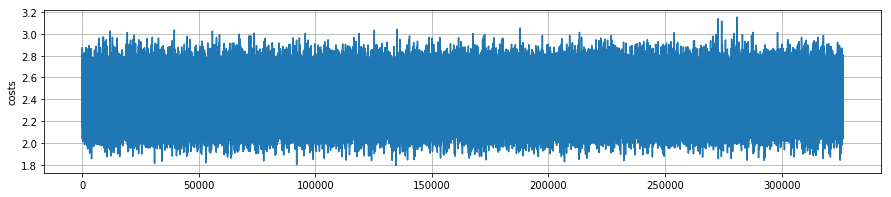

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 半顆, 2017,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 她則, 不對勁, 本魯, 他們,
Nearest to 台灣: 臺灣, 日本, 韓國, 大陸, 香港, 美國, 據傳, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 轉職, 正職, 心智, 越會, 職務, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 排斥, 愛, 想要, 個性, 熱愛, 流行, 常, 22y,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 無法, 願意, 不能, 要, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, 初次, sd, 歷年, 每天晚上, 200, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 漫畫, 大作, 日劇, 片, 新片, 亞絲娜, 誰錯,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 瞬間, 彈幕, 聊個, 壓根, st, 會心,
Nearest to 滿足: 我先, 濫用, 理解, 呼聲, 這還, 寫信, 為過, 不容許, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 另一半, 老公, 廢話,
Nearest to <eos>: sent, 或是, 帶來, 倘若, 之類, 投球, 謝謝, 作答, be, 啾,

epoch38
Iteration  32636  ( 10.0 %) Train mean loss:  2.3845463  ( std:  0.1494725 ) ; run time:  93 [s]
Iteration  65269  ( 20.0 %) Train mean loss:  2.3857982  ( std:  0.14952812 ) ; run time:  187 [s]
Iteration  97908  ( 30.0 %) Train mean loss:  2.3864834  ( std:  0.1491737 ) ; run time:  281 [s]
Iteration  130557  ( 40.0 %) Trai

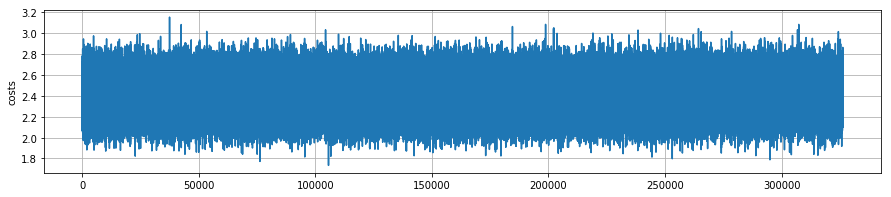

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 半顆, 諒,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 她則, 本魯, 他們,
Nearest to 台灣: 臺灣, 韓國, 日本, 大陸, 香港, 美國, 據傳, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 正職, 轉職, 心智, 職務, 越會, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 愛, 排斥, 想要, 熱愛, 個性, 流行, 常, 22y,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 願意, 要, 無法, 不能, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, sd, 初次, 歷年, 每天晚上, 200, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 大作, 漫畫, 片, 日劇, 新片, 亞絲娜, 誰錯,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 彈幕, 瞬間, 聊個, 壓根, st, 會心,
Nearest to 滿足: 我先, 濫用, 理解, 呼聲, 這還, 寫信, 不容許, 為過, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 另一半, 老公, 女伴,
Nearest to <eos>: sent, 或是, 帶來, 倘若, 之類, 投球, 作答, be, 謝謝, 啾,

epoch39
Iteration  32629  ( 10.0 %) Train mean loss:  2.3810956  ( std:  0.14874247 ) ; run time:  93 [s]
Iteration  65278  ( 20.0 %) Train mean loss:  2.3822315  ( std:  0.14890632 ) ; run time:  187 [s]
Iteration  97921  ( 30.0 %) Train mean loss:  2.383345  ( std:  0.14912893 ) ; run time:  281 [s]
Iteration  130570  ( 40.0 %) Train 

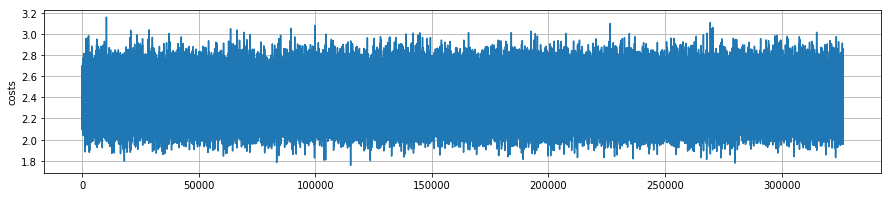

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 諒, 追緝,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 她則, 本魯, 他們,
Nearest to 台灣: 臺灣, 韓國, 日本, 大陸, 香港, 據傳, 美國, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 正職, 轉職, 心智, 職務, 越會, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 排斥, 愛, 想要, 熱愛, 個性, 流行, 22y, 常,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 願意, 要, 無法, 不能, 才能,
Nearest to 約: 大約, 超過, 記念, 說原, sd, 初次, 歷年, 每天晚上, 200, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 漫畫, 大作, 日劇, 片, 新片, 誰錯, 亞絲娜,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 彈幕, 瞬間, 聊個, 壓根, st, 會心,
Nearest to 滿足: 我先, 濫用, 理解, 呼聲, 這還, 寫信, 不容許, 為過, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 熟人, 他, 離過婚, 另一半, 老公, 女伴,
Nearest to <eos>: sent, 或是, 帶來, 倘若, 之類, 投球, 作答, be, 謝謝, 啾,

epoch40
Iteration  32638  ( 10.0 %) Train mean loss:  2.3783028  ( std:  0.1505664 ) ; run time:  94 [s]
Iteration  65280  ( 20.0 %) Train mean loss:  2.3785799  ( std:  0.15040185 ) ; run time:  188 [s]
Iteration  97899  ( 30.0 %) Train mean loss:  2.3796928  ( std:  0.15018076 ) ; run time:  281 [s]
Iteration  130532  ( 40.0 %) Train 

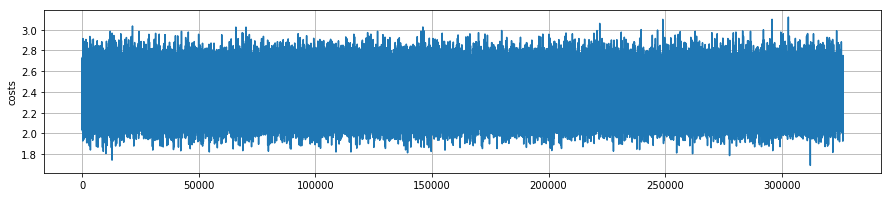

Nearest to <go>: 銘言, 題, 報導, 知道, 成行, 鬼神, 銅鑼, 王妃, 諒, 追緝,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 不對勁, 本魯, 她則, 他們,
Nearest to 台灣: 臺灣, 韓國, 日本, 大陸, 香港, 據傳, 美國, 西班牙, 中國, 國片,
Nearest to 工作: 上班, 台達, 取而代之, 薪資, 正職, 轉職, 心智, 職務, 越會, 幻術,
Nearest to 喜歡: 討厭, 喜愛, 排斥, 愛, 想要, 熱愛, 個性, 流行, 22y, 常,
Nearest to 可以: 能夠, 能, 可, 只能, 還能, 要, 願意, 無法, 不能, 樂於,
Nearest to 約: 大約, 超過, 記念, 說原, 初次, sd, 歷年, 200, 每天晚上, 凹,
Nearest to 電影: 喜劇, 動畫, 展覽, 大作, 漫畫, 片, 日劇, 新片, 亞絲娜, 誰錯,
Nearest to 時間: 捨得, 日期, 催婚, 鎖門, 彈幕, 聊個, 瞬間, 壓根, 會心, st,
Nearest to 滿足: 我先, 濫用, 理解, 呼聲, 這還, 寫信, 不容許, 為過, 我害, 相較,
Nearest to 閃光: 男友, 她, 女友, 金鋼, 他, 熟人, 離過婚, 另一半, 老公, 女伴,
Nearest to <eos>: sent, 或是, 帶來, 倘若, 之類, 投球, be, 作答, 謝謝, 啾,

Elapsed time in total: 37764


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
################################################################
# Set parameter
################################################################
patience = 0
num_epoch = 40
batch_size = 128
embedding_size = 300 # Dimension of the embedding vector.
w2v_lr = 0.1
exp_decay_rate = 0.8
vocab_size = len(vocab)
num_instances = sum_context_size
iter_per_epoch = num_instances // batch_size

exp_decay_steps = sum_context_size // batch_size
similar_nn_num = 10 # number of nearest neighbors

valid_examples = [vocab[GO_id],vocab['我'],vocab['台灣'],vocab['工作'],
                   vocab['喜歡'],vocab['可以'],vocab['約'],vocab['電影'],
                   vocab['時間'],vocab['滿足'],vocab['閃光'],vocab[EOS_id]]
number_sampled = 10 # Number of negative examples to sample.

################################################################
# Build Embedding model
################################################################
def word2vector_model():
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')
    train_labels = tf.placeholder(tf.int32, shape=[None, 1], name='train_labels')
    
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embedding_size], -1.0, 1.0),
                             name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct the variables for the softmax
    nce_weights = tf.Variable(tf.truncated_normal([vocab_size+1, embedding_size],
                                                  stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size+1]))
    
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=number_sampled,
                                         num_classes=vocab_size+1),
                         name='nce_cost')
    # We use the SGD optimizer.
    global_step = tf.Variable(0, trainable=False)
    dynam_w2v_lr = tf.train.exponential_decay(w2v_lr, global_step, exp_decay_steps, 
                                                           exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=dynam_w2v_lr).minimize(loss, 
                                                name='optimizer')
    return train_inputs, train_labels, loss, optimizer, embeddings
    
################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
build_new_model = 1
if build_new_model:
    str_epoch = 0
    model_name = 'PTT_Words_Embedding_' + str(total_start_t)
else:
    str_epoch = 50
    model_name = 'PTT_Words_Embedding_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

iter_pct10 = num_instances // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0

################################################################
# Run model session
################################################################
word2vector_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with word2vector_graph.as_default():
        train_inputs, train_labels, cost, optimizer, embeddings = word2vector_model()

with tf.Session(graph=word2vector_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        train_inputs = word2vector_graph.get_tensor_by_name('train_inputs:0')
        train_labels = word2vector_graph.get_tensor_by_name('train_labels:0')
        loss = word2vector_graph.get_tensor_by_name('nce_cost')
        optimizer = word2vector_graph.get_operation_by_name('optimizer')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        batch_counts = 0
        iter_count = 0
        X_batch = []
        Y_batch = []
        for i in range(num_instances):
            rand_input = total_inputs[rand_idxs[i]]
            rand_label = total_labels[rand_idxs[i]]
            vocab_rand = np.random.uniform(0.0, 1.0)
            if rand_label!=0 and vocab_rand < vocab_rate[rand_input]:
                X_batch.append(rand_input)
                Y_batch.append(rand_label)
                batch_counts = (batch_counts + 1) % batch_size
                
                if batch_counts % batch_size == 0:
                    iter_count += 1
                    X_batch = np.array(X_batch)
                    Y_batch = np.array(Y_batch)
                    optimizer_op, loss = sess.run( [optimizer, cost],
                                        {train_inputs: X_batch, train_labels: Y_batch})
                    X_batch = []
                    Y_batch = []
                    if np.isnan(loss):
                        print('\n!!!! Loss is NaN! !!!!')
                        print('NaN epoch: ', e, ' ; NaN iteration: ', iter_count)
                        print('The last loss: ', last_loss)
                        print('Optimizer: ', optimizer_op)
                        print('The last optimizer: ', last_optimizer_op)
                        break
                    else:
                        costs.append(loss)
                        last_loss = loss
                        last_optimizer_op = optimizer_op
            
            if (i+1) % iter_pct10 == 0:
                costs_pct10 = np.array(costs[-iter_pct10:])
                print('Iteration ',iter_count,' (',round(i*100/num_instances,2),'%) Train mean loss: ',
                      costs_pct10.mean(), ' ( std: ', costs_pct10.std(), 
                      ') ; run time: ', int(time.time() - start_t), '[s]')
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! ', best_costs_mean)
        else:
            early_stop_counter += 1
            print('Count early stop!! ', early_stop_counter)

        print('Elapsed time in epoch ', e+1, ': ', int(time.time() - start_t), 
              ' [s]: iteration number: ', iter_count)
        
        if e==0:
            mdl_dir = os.path.join(base_dir, 'model')
            if not os.path.exists(mdl_dir):
                os.makedirs(mdl_dir)
            model_dir = os.path.join(mdl_dir, model_name)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        embeddings_epoch = embeddings.eval()
        norm = np.sqrt(np.sum(np.square(embeddings_epoch), 1, keepdims=True))
        normalized_embeddings = embeddings_epoch / norm
        valid_embeddings = np.array([normalized_embeddings[valid] for valid in valid_examples])
        similarity = np.matmul(valid_embeddings, np.transpose(normalized_embeddings))
        
        for i, example  in enumerate(valid_examples):
            nearest = (-similarity[i, :]).argsort()[1:similar_nn_num+1]
            log = 'Nearest to %s:' % vocab_reverse[example]
            for k in range(similar_nn_num):
                close_word = vocab_reverse[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_Words_Embedding_1523515706.365372\model-40


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['msjh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


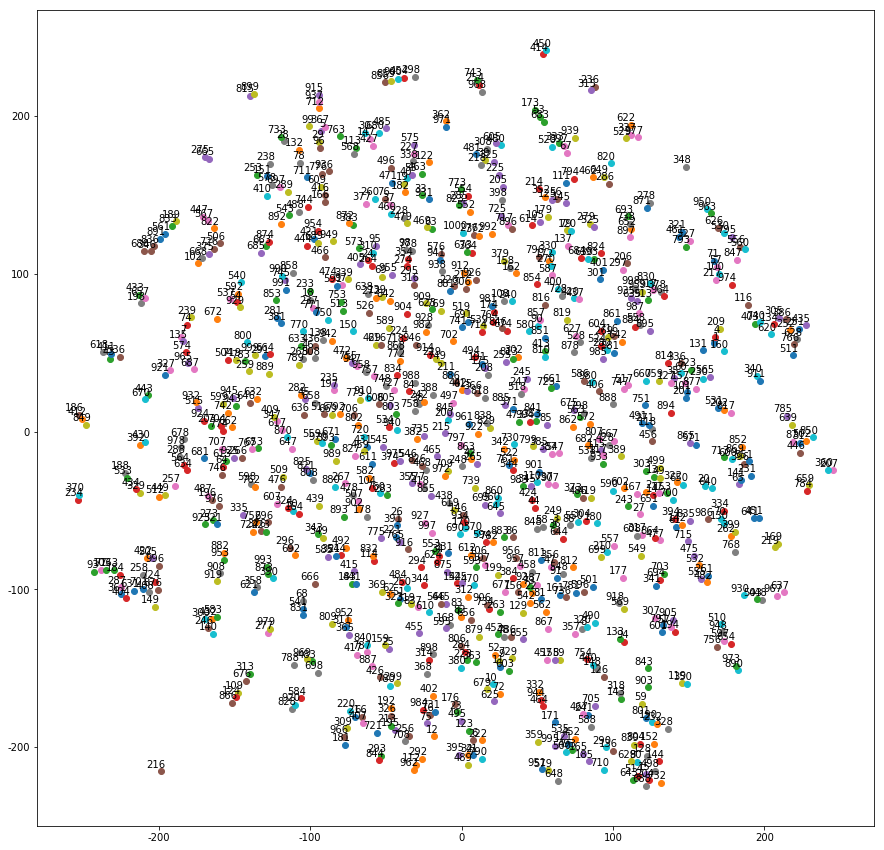

1 的
2 我
3 是
4 了
5 在
6 有
7 <go>
8 <eos>
9 也
10 就
11 都
12 不
13 你
14 他
15 很
16 會
17 她
18 說
19 跟
20 人
21 可以
22 但
23 要
24 看
25 想
26 好
27 自己
28 到
29 去
30 為
31 一個
32 沒有
33 被
34 因為
35 嗎
36 就是
37 讓
38 覺得
39 電影
40 和
41 沒
42 喜歡
43 什麼
44 還是
45 對
46 知道
47 所以
48 真的
49 妳
50 工作
51 如果
52 又
53 上
54 朋友
55 與
56 後
57 這
58 不是
59 這樣
60 吧
61 我們
62 希望
63 一起
64 公司
65 大家
66 能
67 中
68 多
69 做
70 女生
71 那
72 才
73 但是
74 nameid
75 不會
76 把
77 2
78 開始
79 現在
80 比較
81 而
82 應該
83 可能
84 感覺
85 時間
86 再
87 個
88 只是
89 或
90 時候
91 然後
92 不過
93 1
94 之
95 一下
96 來
97 看到
98 找
99 著
100 這個
101 啊
102 月
103 3
104 問題
105 最後
106 其實
107 雖然
108 年
109 大
110 一直
111 時
112 不要
113 用
114 請
115 女友
116 一
117 男友
118 怎麼
119 已經
120 目前
121 很多
122 等
123 還有
124 小
125 之後
126 一樣
127 呢
128 更
129 卻
130 男生
131 的話
132 從
133 引述
134 還
135 銘言
136 有點
137 最近
138 認識
139 吃
140 台灣
141 各位
142 他們
143 這種
144 最
145 前
146 約
147 以
148 像
149 打
150 發現
151 出來
152 太
153 對方
154 好像
155 或是
156 而且
157 啦
158 只
159 想要
160 得
161 結果
162 只有
163 4
164 生活
165 一些
166 完
167 小弟
168 一定
169 男
17

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
################################################################
# Load Embedding model
################################################################

str_epoch = 40
model_name = 'PTT_Words_Embedding_1523515706.365372'
mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

word2vector_graph = tf.Graph()
with tf.Session(graph=word2vector_graph) as sess:
    ######## Load model parameters ########
    # Load model and weight parameters
    load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
    loader = tf.train.import_meta_graph(load_model_dir + '.meta')
    loader.restore(sess, load_model_dir)
    # Load named input parameters
    embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
    norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
    normal_embeddings = embeddings / norm
        
'''    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())

    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())'''

from matplotlib.font_manager import FontProperties 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import pylab
from sklearn.manifold import TSNE
################################################################
# Build t-SNE dimensionality reduction for embeddings lookup.
################################################################

#font = FontProperties(fname= r'C:\windows\fonts\Microsoft JhengHei UI\msjh', size=10)
plt.rcParams['font.family']='msjh'#'Microsoft JhengHei UI' # 指定默認字體
plt.rcParams['axes.unicode_minus'] = False # 解決保存圖像是負號'-'顯示為方塊的問題

num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=50000, method='exact')
two_d_embeddings = tsne.fit_transform(normal_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

#words = [vocab_reverse[i] for i in range(1, num_points+1)]
words = [i for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

for i in range(1, num_points+1):
    print(i, vocab_reverse[i])